In [1]:
from functions import *

etapes_path = "../../etapes/"

# Scrapping chart

##  A - Scrapping

In [7]:
years = [str(y) for y in np.arange(2004, 2023, 1)]
weeks = [int(v) for v in np.linspace(1, 52, 12)]
mois = ["janvier", "fevrier", "mars", "avril", "mai", "juin", "juillet", "aout", "septembre", "octobre", "novembre", "decembre"]

In [8]:
dfs_chart = {y : {} for y in years}
data = []

for y in tqdm(years):
    for k, w in enumerate(weeks):
        url = f"https://acharts.co/france_singles_top_100/{y}/{w}"
        rq = get(url)
        m = mois[k]
        if rq.ok:
            soup = BeautifulSoup(rq.text)

            chart = soup.find("table", {"id" : "ChartTable"})
            trs = chart.findAll("tr")[1:]

            for tr in trs:
                music_name = tr.find("span", {"itemprop" : "name"}).text.lower()
                rank = tr.find("span", {"itemprop" : "position"}).text.lower()
                artist_name = tr.find("span", {"itemprop" : "byArtist"}).text[2:-1].lower()
                data.append([m, y, str(rank), str(artist_name), str(music_name)])

charts = pd.DataFrame(data, columns=["mois", "annee", "rank", "artist", "music"])

100%|██████████| 19/19 [02:26<00:00,  7.70s/it]


In [9]:
#Export
charts.to_csv(f"{etapes_path}scrapping chart/charts.csv", index=False, encoding="utf-8-sig")

## B - Analyse

In [10]:
#Load
charts = pd.read_csv(f"{etapes_path}scrapping chart/charts.csv", encoding="utf-8-sig")

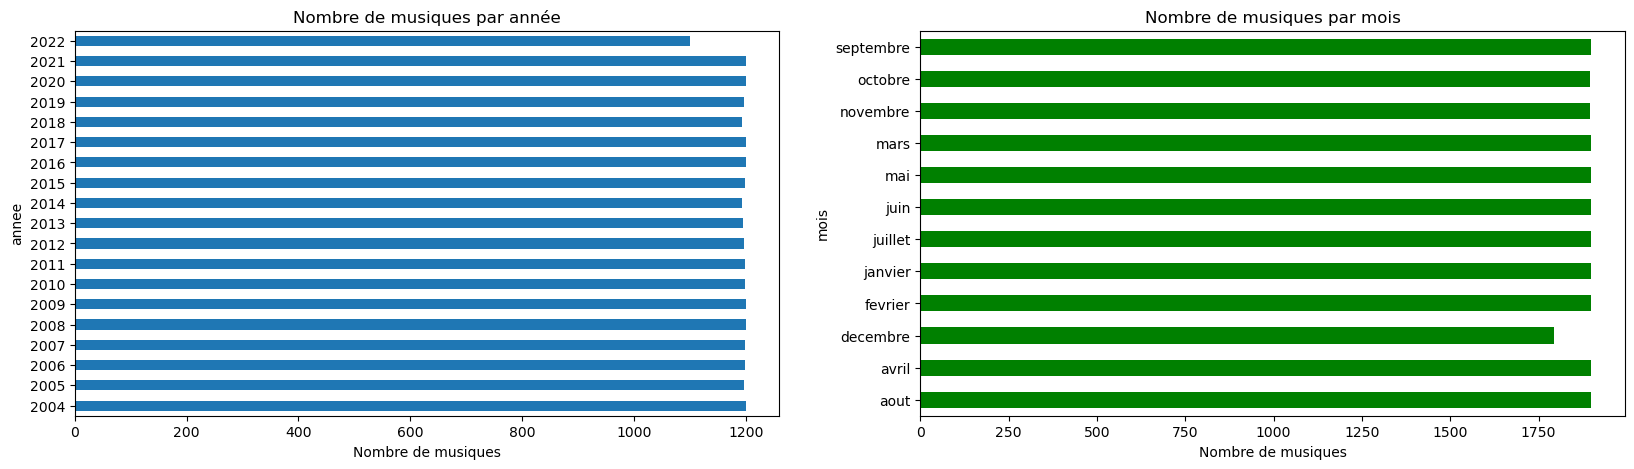

In [11]:
#Donnée par année
fig, ax = plt.subplots(1, 2, figsize=(20,5))
charts.groupby("annee")["music"].count().plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musiques par année", xlabel="Nombre de musiques")

charts.groupby("mois")["music"].count().plot.barh(ax=ax[1], color="green")
ax[1].set(title="Nombre de musiques par mois", xlabel="Nombre de musiques")

plt.show()

# Cleaning chart

## A - Cleaning

In [32]:
#Load
charts = pd.read_csv(f"{etapes_path}scrapping chart/charts.csv", encoding="utf-8-sig")

In [33]:
names = [
    ("Djadja", "Djadja et Dinaz"),
    ("Lorie", "Lorie Pester"),
    ("-m-", "Matthieu Chedid"),
    ("Priscilla", "Priscilla Betti"),
    ("I Am", "IAM"),
    ("Sofiane", "Sofiane Zermani"),
    ("Justice", "Justice (groupe)"),
    ("Soma Riba", "Collectif Métissé"),
    ("Fresh", "Fresh la Peufra"),
    ("Rosalia", "Rosalía"),
    ("Italo Brothers", "ItaloBrothers"),
    ("Far\*east Movement", "Far East Movement"),
    ("Odyssey", "Odyssey (groupe)"),
    ("1789", "1789 : Les Amants de la Bastille"),
    ("Clemence", "Clémence Saint-Preux"),
    ("Rose", "Rose (chanteuse)"),
    ("Laeti", "Laetitia Kerfa"),
    ("La Troupe", "Mozart, l'opéra rock"),
    ("Victoria", "Victoria Sio"),
    ("Christine And The Queens", "Redcar (artiste)"),
    ("Earth and Wind And Fire", "Earth, Wind And Fire"),
    ("Jean Roch", "Jean-Roch"),
    ("Keen V", "Keen'V"),
    ("Dinor", "Dinor RDT"),
    ("Koba La D", "Koba LaD"),
    ("scotts", "Travis Scott"),
    ("louane emera", "louane"),
    ("maitre gims", "gims"),
    ("p!nk", "pink"),
    ("Eva", "Eva Queen"),
    ("dj tiësto", "tiesto"),
    ("Karol", "Karol G"),
    ("Khaled", "DJ Khaled"),
    ("Black Eyed Peas", "The Black Eyed Peas"),
    ("L.E.J", "LEJ"),
    ("Disiz la peste", "Disiz"),
    ("k'maro", "k. maro"),
    ("shin sekaï", "The Shin Sekaï"),
    ("the niro", "niro"),
    ("r.i.o.", "rio"),
    ("zayn", "zayn malik"),
    ("dimitri vegas", "dimitri vegas & like mike"),
    ("cauet", "Sébastien Cauet"),
    ("do", "the do"),
    ("les filles", "Aurélie Konaté")
]

replace_words = [
    ("\x9c", "oe"),
    ("œ", "oe"),
    ("$", "S"),
]

charts["artist"] = charts["artist"].str.split(" x ", regex=False).str[0]
charts["artist"] = charts["artist"].str.split(" - ", regex=False).str[-1]
charts["artist"] = charts["artist"].str.split(" \+ ", regex=False).str[0]

charts["artist"] = charts["artist"].apply(lambda x: "star academy" if "star academy" in x else x)

for n1, n2 in names:
    charts["artist"] = charts["artist"].apply(lambda x: n2.lower() if x.lower() == n1.lower() else x.lower())

for n1, n2 in replace_words:
    charts["artist"] = charts["artist"].str.replace(n1.lower(), n2.lower(), regex=False)


In [34]:
charts = add_id(charts, ["artist", "music"], "id_music")

In [35]:
#Export
charts.to_csv(f"{etapes_path}cleanning chart/charts.csv", index=False, encoding="utf-8-sig")

## B - Analyse

In [27]:
#Load
charts = pd.read_csv(f"{etapes_path}cleanning chart/charts.csv", encoding="utf-8-sig")

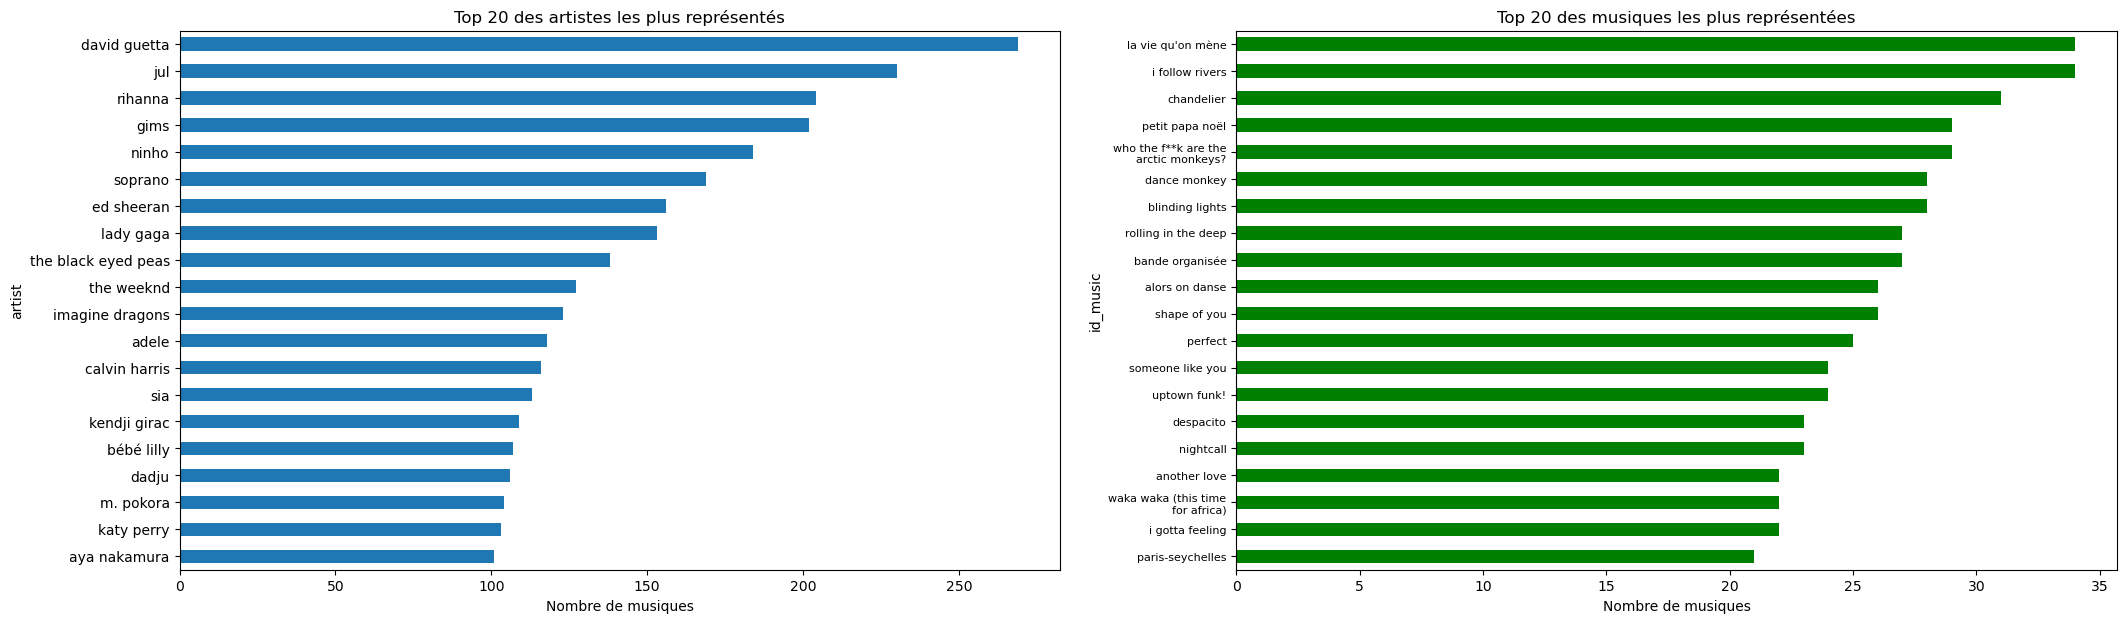

In [17]:
top = 20

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("artist")["music"].count().sort_values().iloc[-top:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top {top} des artistes les plus représentés", xlabel="Nombre de musiques")

charts.groupby("id_music")["artist"].count().sort_values().iloc[-top:].plot.barh(ax=ax[1], color="green")
ax[1].set(title=f"Top {top} des musiques les plus représentées", xlabel="Nombre de musiques")
ax[1].set_yticklabels(["\n".join(wrap(charts[charts["id_music"] == int(elem.get_text())].iloc[0,:]["music"], 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

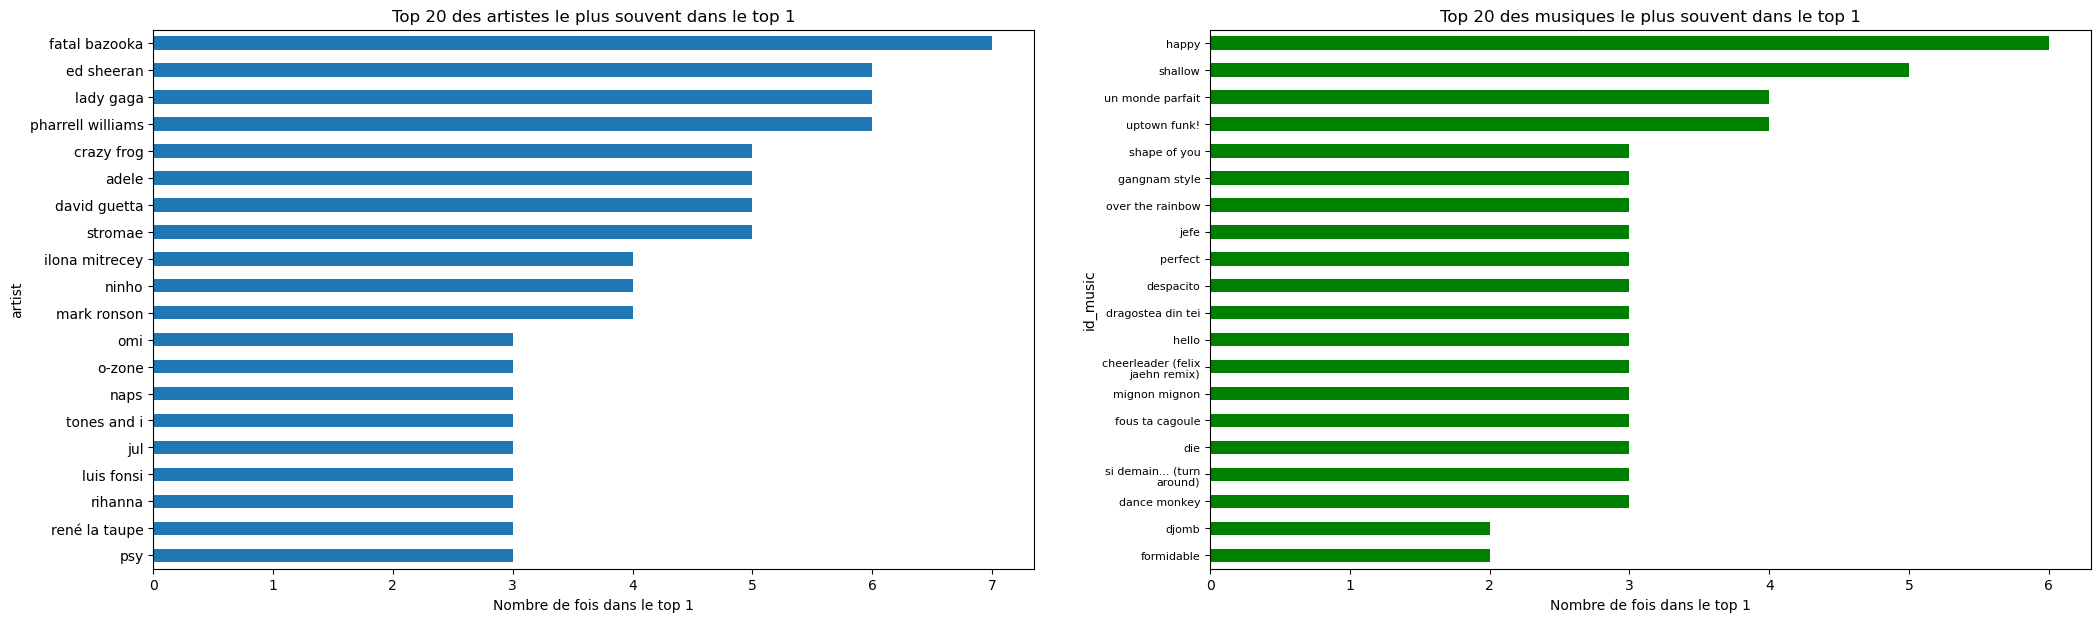

In [18]:
top = 1

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("artist")["rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values().iloc[-20:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top 20 des artistes le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")

charts.groupby("id_music")["rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values().iloc[-20:].plot.barh(color="green", ax=ax[1])
ax[1].set(title=f"Top 20 des musiques le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")
ax[1].set_yticklabels(["\n".join(wrap(charts[charts["id_music"] == int(elem.get_text())].iloc[0,:]["music"], 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

David Guetta est l'artiste qui a eu le souvent ses musiques dans les top 5 français. </br>
Shallow est la musique qui est revenu le plus souvent dans le top 5.

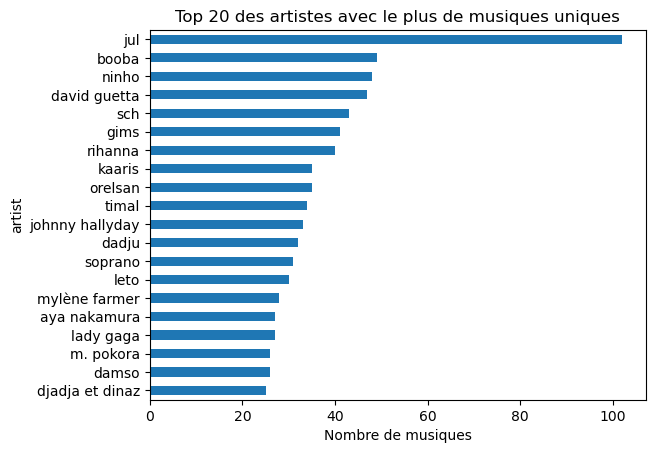

In [19]:
charts.groupby("artist")["id_music"].unique().agg(len).sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes avec le plus de musiques uniques")
plt.xlabel("Nombre de musiques")
plt.show()

Jul est l'artiste avec le plus de musique unique dans le top 100 depuis 2004

# Scrapping artist data

## A - Scrapping

In [54]:
#Load
charts = pd.read_csv(f"{etapes_path}cleanning chart/charts.csv", encoding="utf-8-sig")

In [55]:
#Récupére tous les artistes uniques
artists = pd.DataFrame(charts["artist"].unique(), columns=["artist"])

In [56]:
artists["wiki name"] = artists["artist"].apply(lambda x : find_title_in_wikipedia(x, 0.25)) #Trouve les pages wikipedia de chaque artistes

In [57]:
birth_dic = artists["wiki name"].apply(wiki_birth) #Cherche les infos de naissance sur les pages wikipedia

In [58]:
#Transforme les infos trouver sur wikipédia en dataframe
dfs_birth = []
for dic in birth_dic:
    dfs_birth.append(pd.DataFrame(dic, index=[0]))
birth = pd.concat(dfs_birth, ignore_index=True)
birth.columns = ["naissance", "pays d'origine", "origine", "nationalite", "pays", "summary"]

In [59]:
#Merge les infos de naissance avec les infos des artistes
artists = artists.merge(birth, left_index=True, right_index=True)

In [60]:
#On ajoute manuellement les informations pour les artistes importants qui n'ont pas été trouvé sur wikipedia
manuel_names = [
    ("sound of legend", "manuel", np.nan, np.nan, np.nan, "français", np.nan, np.nan),
    ("al. hy", "manuel", "15 novembre 1993", np.nan, np.nan, "français", np.nan, "15 novembre 1993 (Âge: 29 ans), Saint-Amand-les-Eaux"),
    ("glk", "manuel", np.nan, np.nan, np.nan, "français", np.nan, "Originaire de Bobigny, en Seine-Saint-Denis"),
    ("paul glaeser", "manuel", "1963", np.nan, np.nan, "français", np.nan, np.nan),
    ("bolémvn", "manuel", "29 novembre 1996", np.nan, np.nan, "français", np.nan, "Bryan Mounkala (né le 29 novembre 1996) mieux connu sous le nom de Bolémvn est un rappeur français d'Évry, Essonne, Île-de-France, France."),
    ("1pliké140", "manuel", "2001", np.nan, np.nan, "français", np.nan, "1PLIKÉ140 est un jeune rappeur français originaire de Clamart (92) en banlieue parisienne."),
    ("jérôme collet", "manuel", np.nan, np.nan, np.nan, "français", np.nan, np.nan),
    ("tom snare", "manuel", np.nan, np.nan, np.nan, "français", np.nan, "Xavier Decanter, mieux connu sous son nom de scène Tom Snare, est un DJ et producteur de disques français originaire de Dunkerque."),
    ("funnybear", "manuel", "22 janvier 1991", np.nan, np.nan, "français", np.nan, "22 janvier 1991 (Âge: 31 ans), Hyères"),
    ("landy", "manuel", "2000", np.nan, np.nan, "français", np.nan, "Dylan Sylla Gahoussou, « Landy » de son nom de scène, est né dans le XIXe arrondissement de Paris"),
    ("dry", "manuel", "19 novembre 1977", np.nan, np.nan, "français", np.nan, "Landry Delica a grandi à Sevran en Seine-Saint-Denis"),
    ("sasso", "manuel", np.nan, np.nan, np.nan, "français", np.nan, "Né à Vénissieux d'un père togolais et d'une mère marocaine"),
    ("neïman", "manuel", np.nan, np.nan, np.nan, "guyanais", np.nan, "NEÏMAN est un chanteur et toaster français de dancehall et de reggae-soul né RAY NEÏMAN en Guyane."),
    ("isk", "manuel", "20 mars 2003", np.nan, np.nan, "français", np.nan, "ISK, de son vrain nom Kais Ben Baccar, est un rappeur français d'origine tunisienne, né au Canada. Habitant La Ferté-sous-Jouarre (77), il est membre du label Bendo 11 Records sous la division rap GrandLine."),
    ("yaro", "manuel", "1996", np.nan, np.nan, "français", np.nan, "Yaro, anciennement Sirsy, est un rappeur français originaire de la ville de Yerres dans l'Essonne.")
]

In [61]:
manuel_artist = pd.DataFrame(manuel_names, columns=["name", "wiki name", "naissance", "pays d'origine", "origine", "nationalite", "pays", "summary"])

In [62]:
artist_to_drop = artists[artists["artist"].isin(manuel_artist["name"])].index
artists.drop(index=artist_to_drop, inplace=True)
artists.rename(columns={"artist" : "name"}, inplace=True)

In [63]:
artists = pd.concat([artists, manuel_artist])

In [92]:
#Export
artists.to_csv(f"{etapes_path}scrapping artist data/artists.csv", encoding="utf-8-sig", index=False)

## B - Analyse

In [91]:
#Load
artists = pd.read_csv(f"{etapes_path}scrapping artist data/artists.csv", encoding="utf-8-sig")

In [66]:
artists.value_counts("wiki name").value_counts() #Aucune page en wiki en double, ce qui est un bon signe !

1     1724
15       1
dtype: int64

In [67]:
charts_c = charts.copy().drop(columns=["rank", "annee", "mois"]).drop_duplicates()
charts_c = charts_c.merge(artists, left_on="artist", right_on="name", how="left")

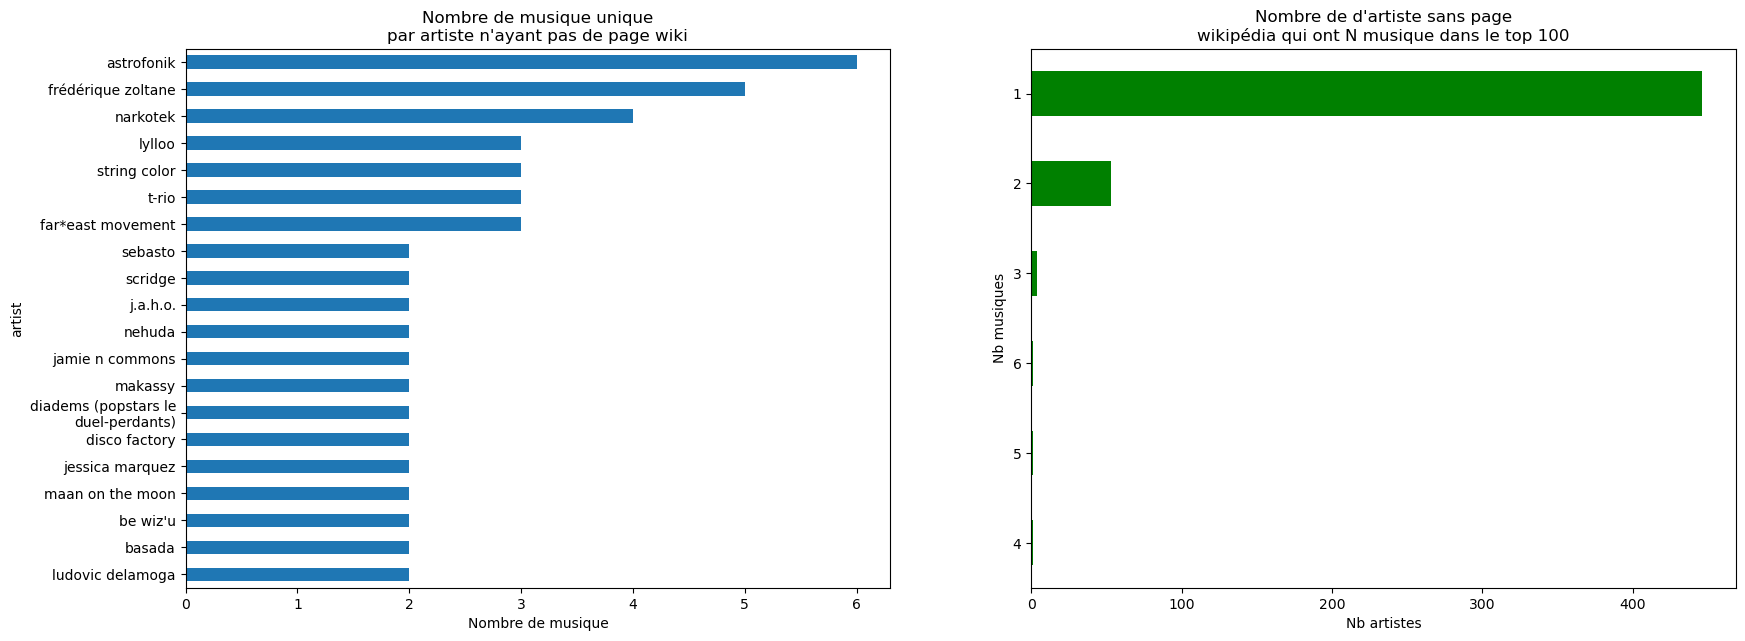

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

charts_c[charts_c["wiki name"].isna()].groupby("artist")["music"].count().sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musique unique\npar artiste n'ayant pas de page wiki", xlabel="Nombre de musique")
ax[0].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[0].get_yticklabels()])


charts_c[charts_c["wiki name"].isna()].groupby("artist")["music"].count().value_counts()[::-1].plot.barh(ax=ax[1], color="green")
ax[1].set(xlabel="Nb artistes", ylabel="Nb musiques", title="Nombre de d'artiste sans page\nwikipédia qui ont N musique dans le top 100")
plt.show()

On remarque qu'il y a beaucoup d'artistes qui n'ont fait qu'une ou deux musiques populaires, ce qui parait logique de ne pas trouver beaucoup d'information sur eux. </br>
Seul quelques artistes sortent du lot, et après recherche, soit l'artiste n'est pas français, soit il y a trop peu d'infos sur eux.

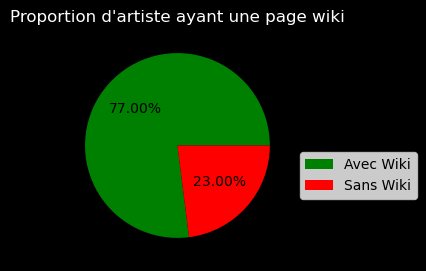

In [69]:
pie_chart(artists, "wiki name", "Proportion d'artiste ayant une page wiki", legends=["Avec Wiki", "Sans Wiki"])

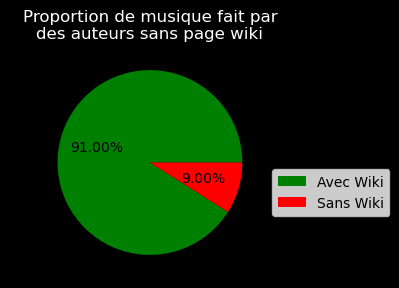

In [70]:
pie_chart(charts_c, "wiki name", "Proportion de musique fait par\ndes auteurs sans page wiki", legends=["Avec Wiki", "Sans Wiki"])

In [71]:
artists = artists[~artists["wiki name"].isna()] #On ne garde que les artistes qui ont une page wiki

In [72]:
artists["distance"] = artists.apply(lambda x: calc_dist(x["name"], x["wiki name"]), axis=1)
artists["distance norm"] = artists.apply(lambda x : x["distance"]/len(x["name"]), axis=1)

In [73]:
artists.sort_values("distance norm", ascending=False).head() #Nos distances sont bonnes

,name,wiki name,naissance,pays d'origine,origine,nationalite,pays,summary,distance,distance norm
1575,years & years,Years and Years,NaN,royaume-uni,NaN,NaN,royaume-uni,years and years était un groupe de musique bri...,3,0.230769
456,les squatters,The Squatters,NaN,NaN,NaN,NaN,NaN,the squatters est un film muet américain réali...,3,0.230769
749,c project,Project,NaN,NaN,NaN,NaN,NaN,project peut faire référence à :,2,0.222222
913,cidinho & doca,Cidinho and Doca,NaN,NaN,NaN,NaN,NaN,"cidinho and doca (cidinho e doca, ou cidinho &...",3,0.214286
2014,cinematic orchestra,The Cinematic Orchestra,NaN,royaume-uni,NaN,NaN,royaume-uni,the cinematic orchestra est un groupe britanni...,4,0.210526


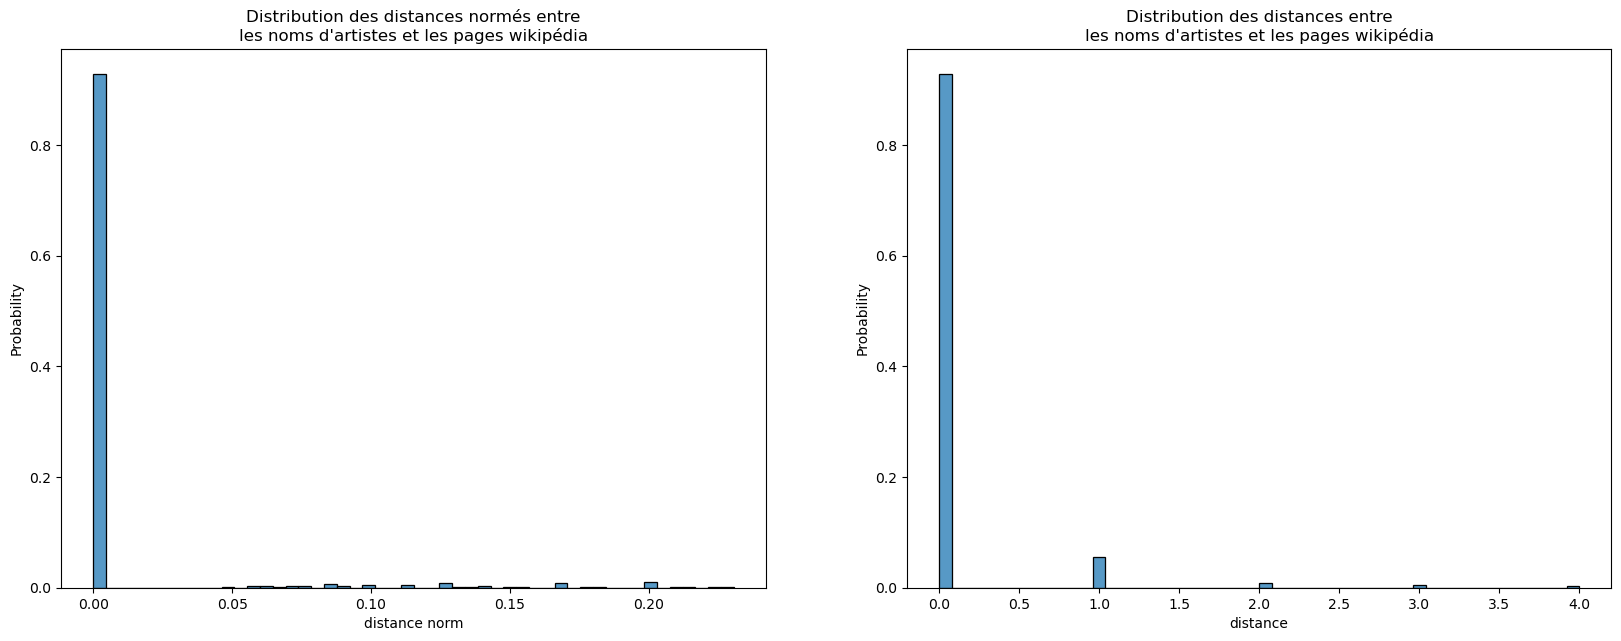

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(x = "distance norm", data=artists, bins=50, stat="probability", ax=ax[0])
ax[0].set_title("Distribution des distances normés entre\nles noms d'artistes et les pages wikipédia")

sns.histplot(x = "distance", data=artists, bins=50, stat="probability", ax=ax[1])
ax[1].set_title("Distribution des distances entre\nles noms d'artistes et les pages wikipédia")

plt.show()

# Cleanning wikipedia results

## A - nationalite/pays

In [113]:
#Load
artists = pd.read_csv(f"{etapes_path}scrapping artist data/artists.csv", encoding="utf-8-sig")
charts = pd.read_csv(f"{etapes_path}cleanning chart/charts.csv", encoding="utf-8-sig")

In [114]:
nationality_cols = ["nationalite", "origine", "pays", "pays d'origine"]

### 1 - artiste sans donnée

In [115]:
artists_org = artists.copy()

In [116]:
#Ajout de la colonne "no data" pour voir ceux sur qui on n'a pas de données
artists["no data"] = (
    (artists["naissance"].isna()) &
    (artists["pays d'origine"].isna()) &
    (artists["origine"].isna()) &
    (artists["nationalite"].isna()) &
    (artists["pays"].isna()) &
    (artists["summary"].isna())
)

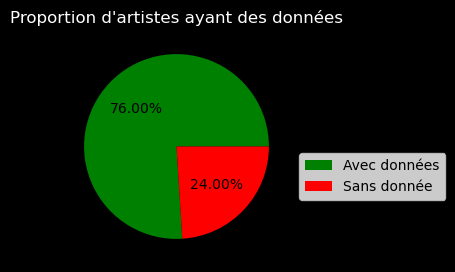

In [117]:
pie_chart(artists, "no data", "Proportion d'artistes ayant des données", False, ["Avec données", "Sans donnée"])

In [118]:
charts_c = charts.copy().merge(artists, left_on="artist", right_on="name", how="right")

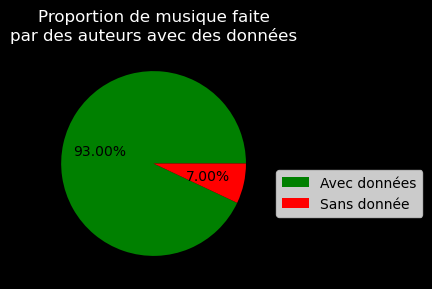

In [119]:
pie_chart(charts_c, "no data", "Proportion de musique faite\npar des auteurs avec des données", False, ["Avec données", "Sans donnée"])

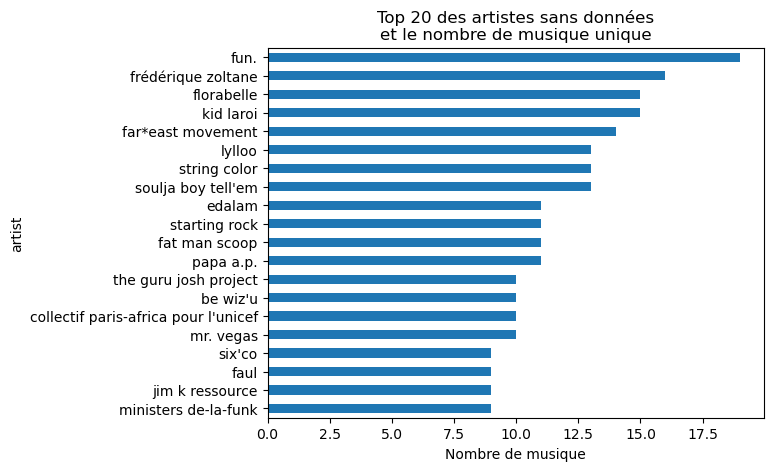

In [120]:
charts_c[charts_c["no data"]].groupby("artist")["music"].count().sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes sans données\net le nombre de musique unique")
plt.xlabel("Nombre de musique")
plt.show()

In [121]:
artists = artists[~artists["no data"]] #On ne garde que les artistes pour lesquels on a des données

### 2 - Normalisation des nationalites et pays récupéré

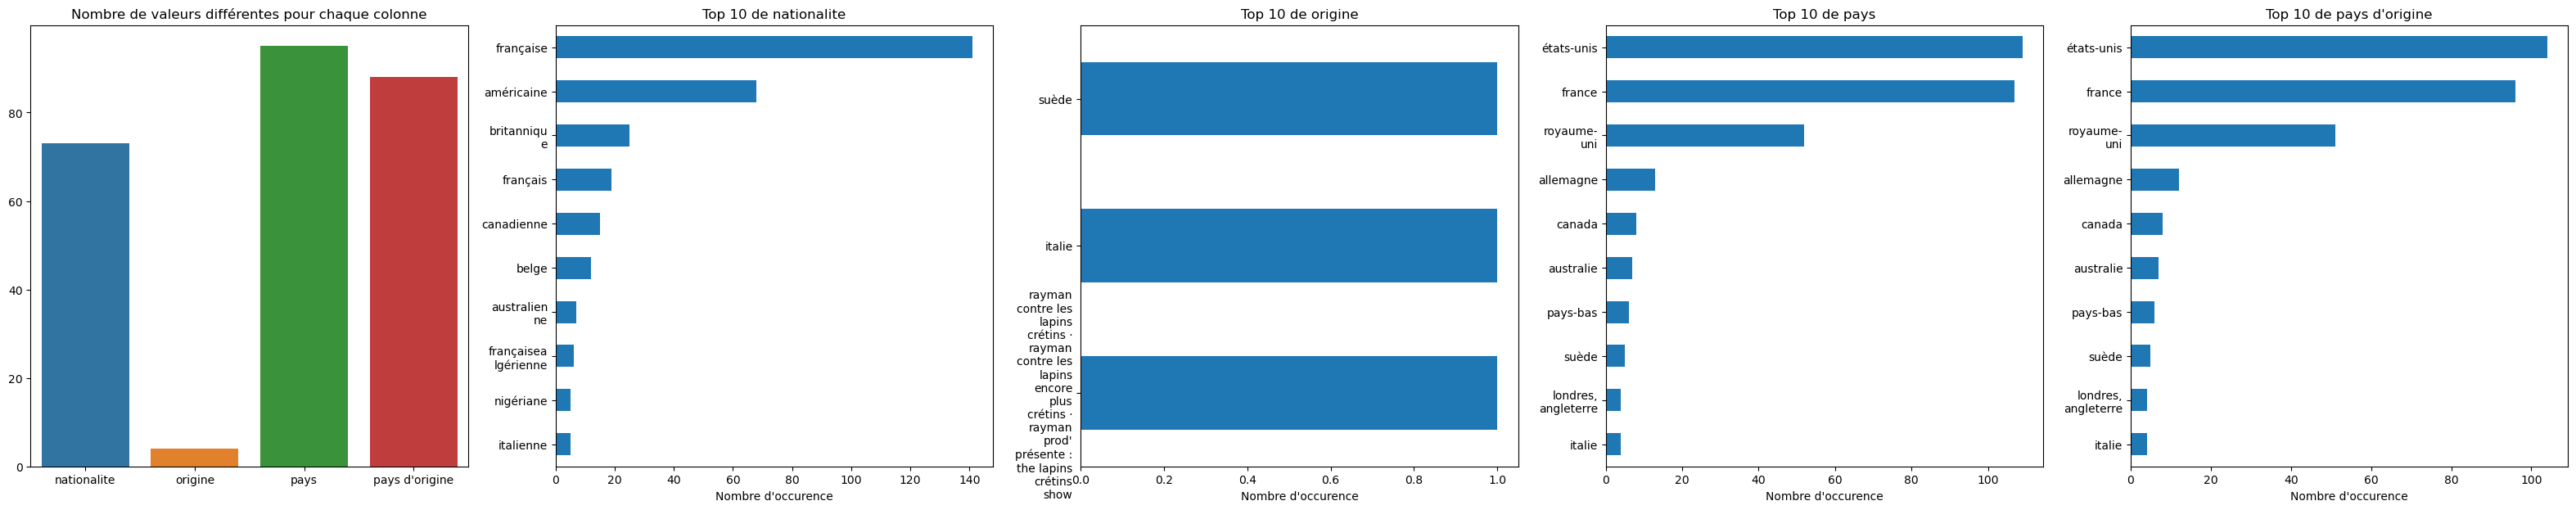

In [122]:
category_count(nationality_cols, artists, top=10)

On se rends compte qu'il y a pleins de nationalite/pays différents et qu'on pourrait en grouper certain.

In [123]:
#On supprime les textes dépassant les 40 caractères
for col in nationality_cols:
    artists.loc[~artists[col].isna(), col] = artists.loc[~artists[col].isna(), col].apply(lambda x: np.NaN if len(x) > 40 else x)

In [124]:
#Importation des pays et des gentillé associer
gentille_df = pd.read_csv("../../monde/gentille.csv")
gentille = gentille_df["gentille"].drop_duplicates().tolist()
pays = gentille_df["pays"].drop_duplicates().tolist()

In [125]:
#On cherche dans les pays si on trouve quelque chose de connu
for p in pays:
    rgx = r"([\d)()\], ]|^)"+ p.lower() + r"([.,\[) ]|$)"
    artists.loc[artists["pays"].str.contains(rgx, regex=True, na=False), "pays"] = p
    artists.loc[artists["pays d'origine"].str.contains(rgx, regex=True, na=False), "pays d'origine"] = p

C:\Users\quent\AppData\Local\Temp\ipykernel_11176\3495446475.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artists.loc[artists["pays"].str.contains(rgx, regex=True, na=False), "pays"] = p
C:\Users\quent\AppData\Local\Temp\ipykernel_11176\3495446475.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artists.loc[artists["pays d'origine"].str.contains(rgx, regex=True, na=False), "pays d'origine"] = p


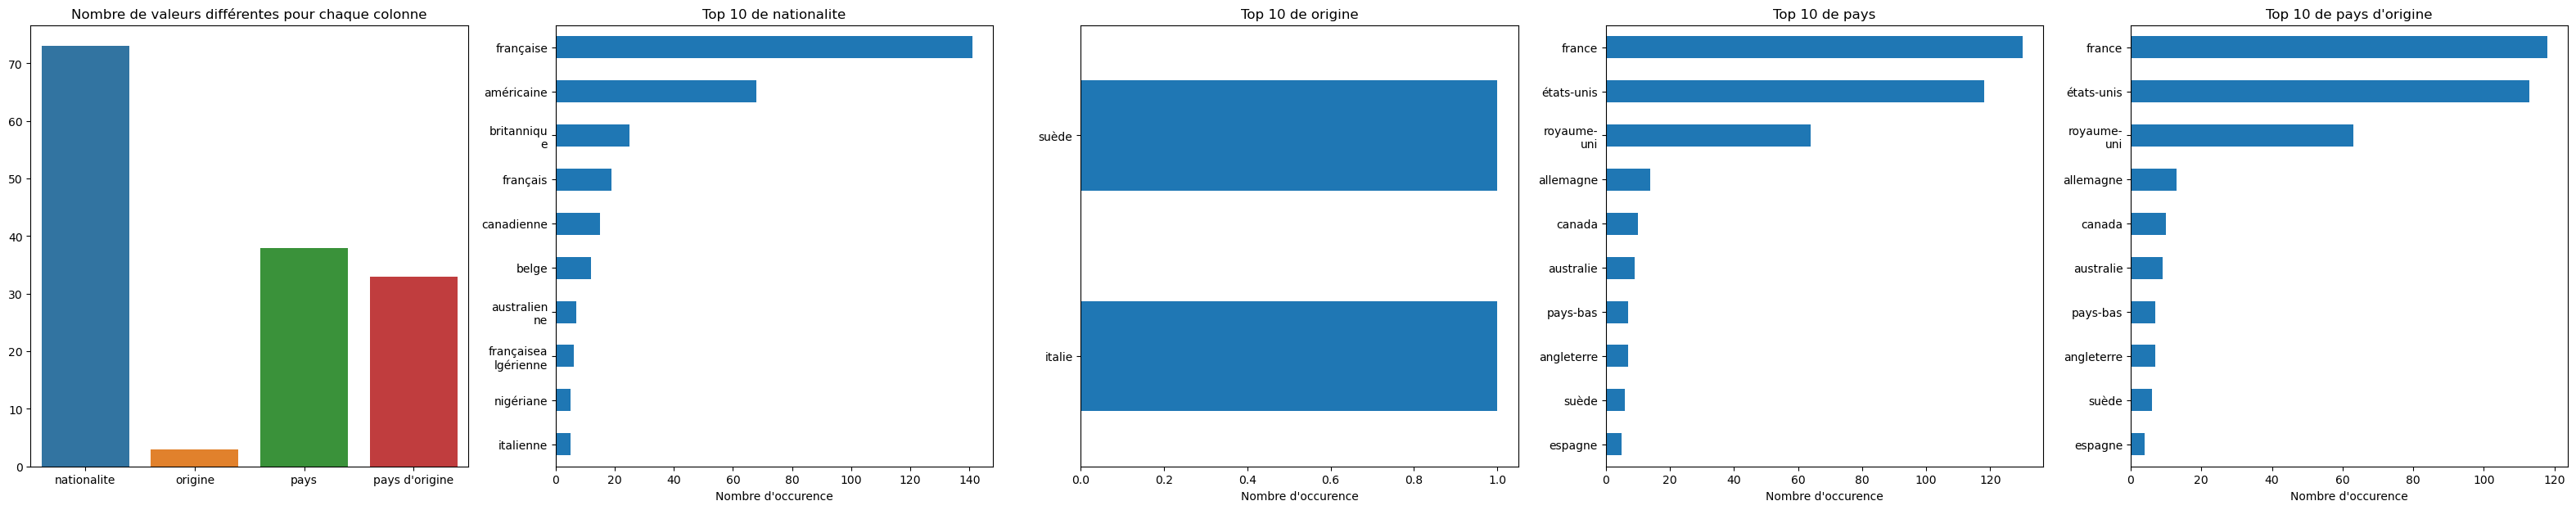

In [126]:
category_count(nationality_cols, artists)

On a enlevé les valeurs aberrantes et réduit de moitié pays et pays d'origne.

In [127]:
artists["nationalite"] = artists["nationalite"].apply(lambda x : cleanning(x, gentille))

In [128]:
artists["origine"] = artists["origine"].apply(lambda x : cleanning(x, pays))
artists["pays"] = artists["pays"].apply(lambda x : cleanning(x, pays))
artists["pays d'origine"] = artists["pays d'origine"].apply(lambda x : cleanning(x, pays))

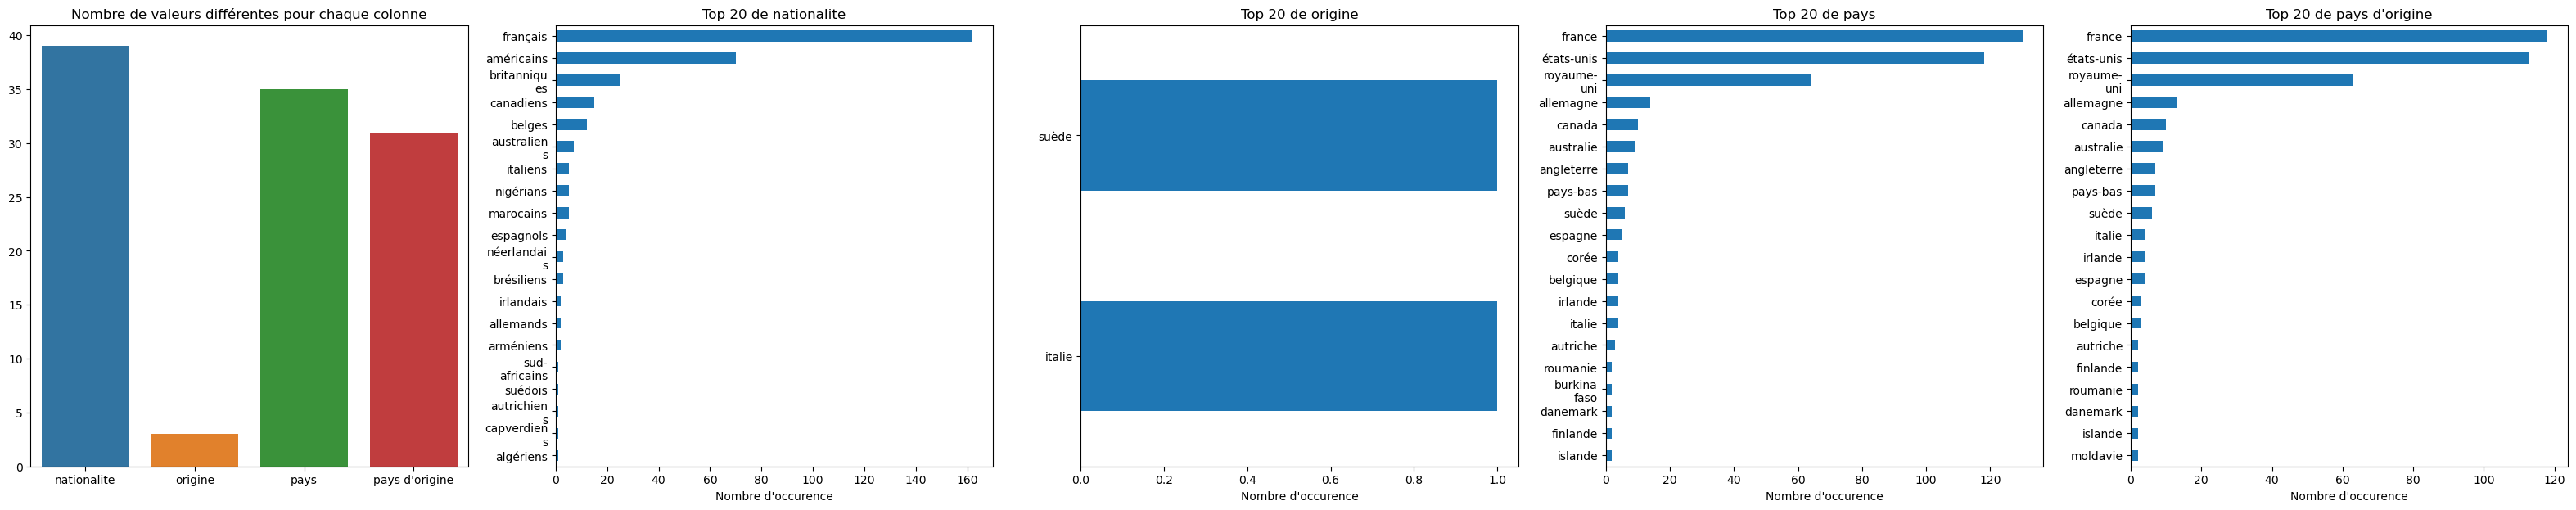

In [129]:
category_count(nationality_cols, artists, top=20)

### 3 - Récupération de nouvelles nationalites et pays

Maintenant que nous avons normalisé l'écriture des pays et nationalite on va essayer d'en chercher de nouveau pour les artistes qui n'en n'ont pas. A l'aide du summary et naissance.

In [130]:
artists["no nationalite"] = (
    (artists["nationalite"].isna()) &
    (artists["origine"].isna()) &
    (artists["pays"].isna()) &
    (artists["pays d'origine"].isna())
)

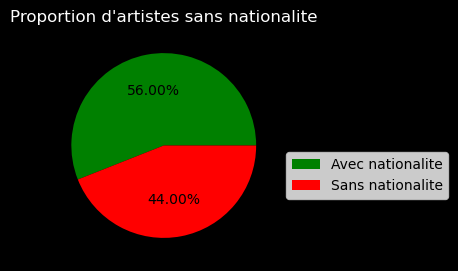

In [131]:
pie_chart(artists, "no nationalite", "Proportion d'artistes sans nationalite", False, ["Avec nationalite", "Sans nationalite"])

In [132]:
#On utilise le summary pour récupérer la nationalite
avant = artists[artists["nationalite"].isna()].shape[0]

nats = artists[~artists["nationalite"].isna()]["nationalite"].unique()
artists.loc[artists["nationalite"].isna(), "nationalite"] = artists.loc[artists["nationalite"].isna(), "summary"].apply(lambda x: get_nationality(x, nats))         #Je récupère une première fois avec les nationalites déjà connues
artists.loc[artists["nationalite"].isna(), "nationalite"] = artists.loc[artists["nationalite"].isna(), "summary"].apply(lambda x: get_nationality(x, gentille))     #Je récupère une deuxième fois avec les gentilles

apres = artists[artists["nationalite"].isna()].shape[0]

print(f"On a récupéré {avant-apres} nationalites")

On a récupéré 425 nationalites


In [133]:
#On utilise le summary pour récupérer la pays
avant = artists[(artists["pays"].isna()) & (artists["nationalite"].isna())].shape[0]

artists.loc[(artists["pays"].isna()) & (artists["nationalite"].isna()), "pays"] = artists.loc[(artists["pays"].isna()) & (artists["nationalite"].isna()), "naissance"].apply(lambda x: get_nationality(x, pays)) #Je récupère une première fois sur les naissances
artists.loc[(artists["pays"].isna()) & (artists["nationalite"].isna()), "pays"] = artists.loc[(artists["pays"].isna()) & (artists["nationalite"].isna()), "summary"].apply(lambda x: get_nationality(x, pays))   #Je récupère une deuxième fois sur le summary

apres = artists[(artists["pays"].isna()) & (artists["nationalite"].isna())].shape[0]

print(f"On a récupéré {avant - apres} pays")

On a récupéré 453 pays


In [134]:
#Mise à jour
artists["no nationalite"] = (
    (artists["nationalite"].isna()) &
    (artists["origine"].isna()) &
    (artists["pays"].isna()) &
    (artists["pays d'origine"].isna())
)

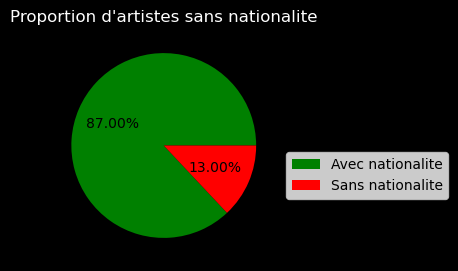

In [135]:
pie_chart(artists, "no nationalite", "Proportion d'artistes sans nationalite", False, ["Avec nationalite", "Sans nationalite"])

In [136]:
avant = artists[artists["nationalite"].isna()].shape[0]

In [137]:
for col in gentille_df.columns:
    gentille_df[col] = gentille_df[col].str.strip()

gentille = pd.DataFrame.to_dict(gentille_df.set_index("pays"), orient="dict").get("gentille")

In [138]:
#On récupère la nationalite à partir du pays et origine
for k, v in gentille.items():
    artists.loc[(artists["nationalite"].isna()) & (artists["pays"] == k), "nationalite"] = v
    artists.loc[(artists["nationalite"].isna()) & (artists["pays d'origine"] == k), "nationalite"] = v
    artists.loc[(artists["nationalite"].isna()) & (artists["origine"] == k), "nationalite"] = v

In [139]:
#ajout manuel
artists.loc[artists["name"].isin(["dadju", "les enfoirés", "rim'k", "akon", "cascada", "ilona mitrecey", "amir"]), "nationalite"] = "français"
artists.loc[artists["name"].isin(["akon"]), "nationalite"] = "américains"
artists.loc[artists["name"].isin(["lily allen"]), "nationalite"] = "britanniques"

In [140]:
apres = artists[artists["nationalite"].isna()].shape[0]
print(f"On a récupéré {avant-apres} nationalites")

On a récupéré 723 nationalites


In [141]:
#Mise à jour
artists["no nationalite"] = (
    (artists["nationalite"].isna()) &
    (artists["origine"].isna()) &
    (artists["pays"].isna()) &
    (artists["pays d'origine"].isna())
)

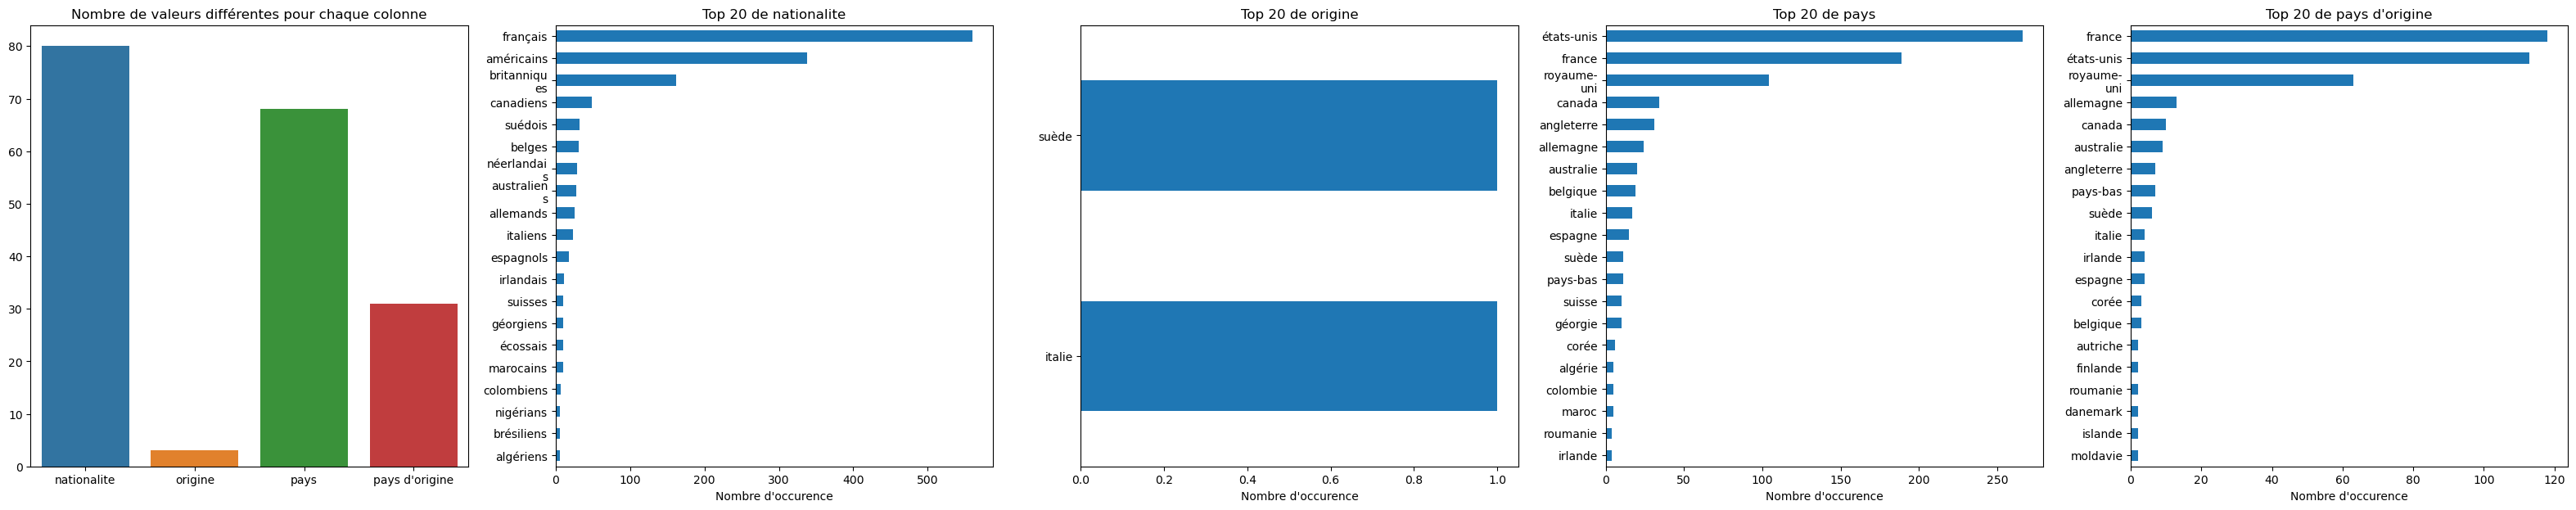

In [142]:
category_count(nationality_cols, artists, top=20)

In [143]:
charts_c = charts.copy().merge(artists, left_on="artist", right_on="name", how="left").drop(columns=["rank","annee", "mois"]).drop_duplicates()

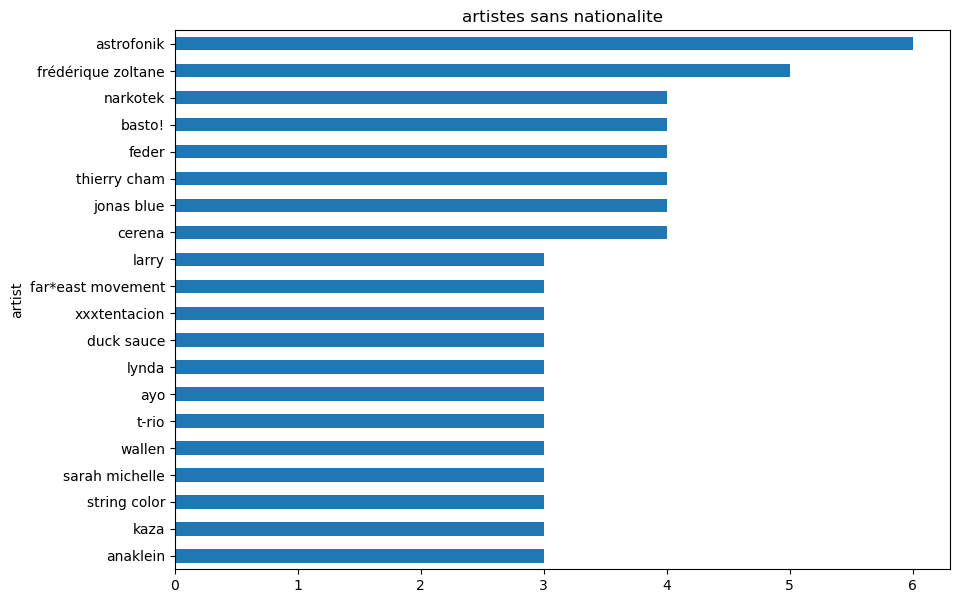

In [144]:
charts_c[charts_c["nationalite"].isna()].groupby("artist")["music"].count().sort_values()[-20:].plot.barh(figsize=(10,7))
plt.title("artistes sans nationalite")
plt.show()

In [95]:
#Export
artists.to_csv(f"{etapes_path}cleanning wikipedia results/nationalite_pays/artists.csv", encoding="utf-8-sig", index=False)

## B - commune/departement/region

In [94]:
#Load
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/nationalite_pays/artists.csv", encoding="utf-8-sig")

In [152]:
#Importation des données
region = pd.read_csv("../../csv/departements-france.csv")
departement = pd.read_csv("../../csv/departements-france.csv")
commune = pd.read_csv("../../csv/communes-departement-region.csv")
nb_habitant = pd.read_csv("../../csv/nb_habitant.csv")

In [153]:
#On supprime les colonnes inutiles
commune = commune.drop(columns = ["code_commune_INSEE", "nom_commune_postal", "code_postal", "libelle_acheminement", "ligne_5", "latitude", "longitude", "code_commune", "article", "code_departement", "code_region", "nom_commune"])

#On rename la colonne nom_commune_complet en nom_commune
commune = commune.rename(columns={"nom_commune_complet": "nom_commune"})

#On enleve les arrondisement des villes
commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"] = commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"].str[:-3]

#On ajoute le nombre d'habitant au commune
commune = commune.merge(nb_habitant[["Ville", "nb_habitant"]], left_on="nom_commune", right_on="Ville", how="inner").drop(columns=["Ville"]).dropna().drop_duplicates()

#On transforme le nb d'habitant en int
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

#On transforme tout en lower
for col in commune.select_dtypes("object").columns:
    commune[col] = commune[col].str.lower()

In [154]:
#On récupère la région
artists["region"] = artists.apply(lambda x: get_localisation(x, commune["nom_region"]), axis=1)

In [155]:
#On récupère la commune
artists["commune"] = artists.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["nom_commune"]), axis=1)

In [156]:
#On récupère le département
artists["departement"] = artists.apply(lambda x: get_localisation(x, commune["nom_departement"]), axis=1)

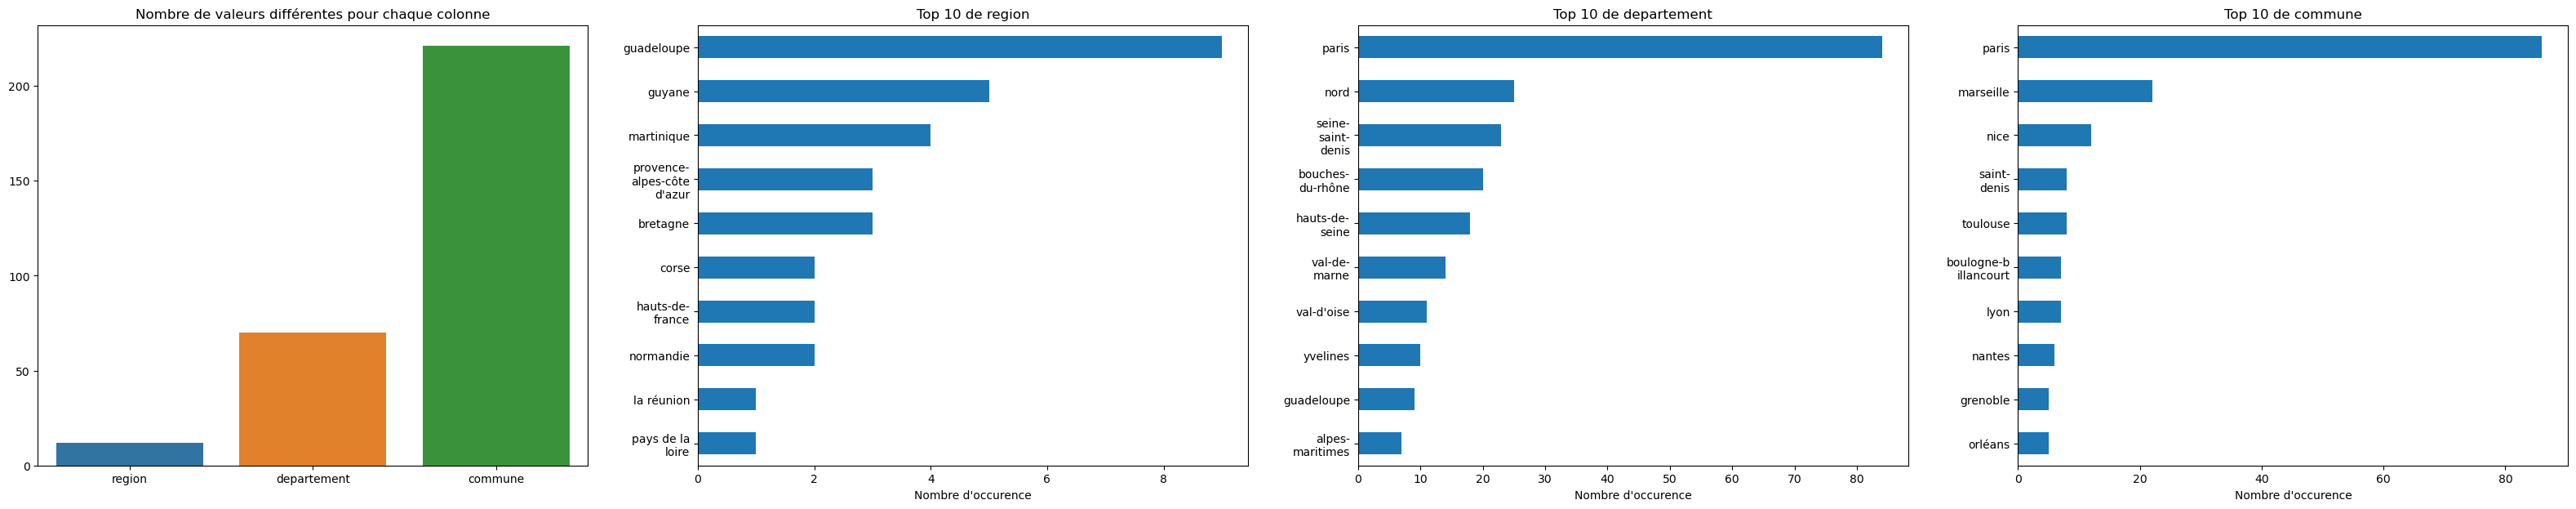

In [157]:
category_count(["region", "departement", "commune"], artists, top=10)

In [158]:
#artiste sans localisation
artists["no localisation"] = (
    (artists["region"].isna()) &
    (artists["commune"].isna()) &
    (artists["departement"].isna())
)

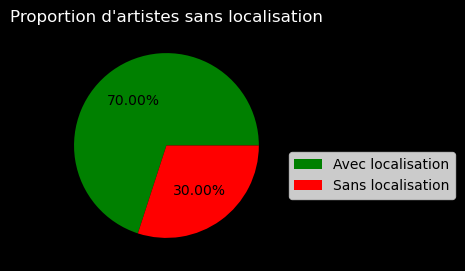

In [159]:
pie_chart(artists, "no localisation", "Proportion d'artistes sans localisation", False, ["Avec localisation", "Sans localisation"])

In [160]:
avant = artists[artists["nationalite"].isna()].shape[0]

# Les artistes pour qui ont a trouvé une commune/departement/region on leur donne la nationalite française
artists.loc[(artists["nationalite"].isna()) & (~artists["no localisation"]), "nationalite"] = "français"

apres = artists[artists["nationalite"].isna()].shape[0]
print(f"On a récupéré {avant-apres} nationalites")

On a récupéré 33 nationalites


In [161]:
#Permet de récupérer le département à partir de la commune
def commune_to_departement(x : str):
    value = commune.loc[commune["nom_commune"] == x, "nom_departement"].values
    if len(value) > 0:
        return value[0]
    else:
        return np.NaN

In [162]:
#On ajoute les departements pour les communes
artists.loc[(~artists["commune"].isna()) & (artists["departement"].isna()), "departement"] = artists.loc[(~artists["commune"].isna()) & (artists["departement"].isna()), "commune"].apply(commune_to_departement)

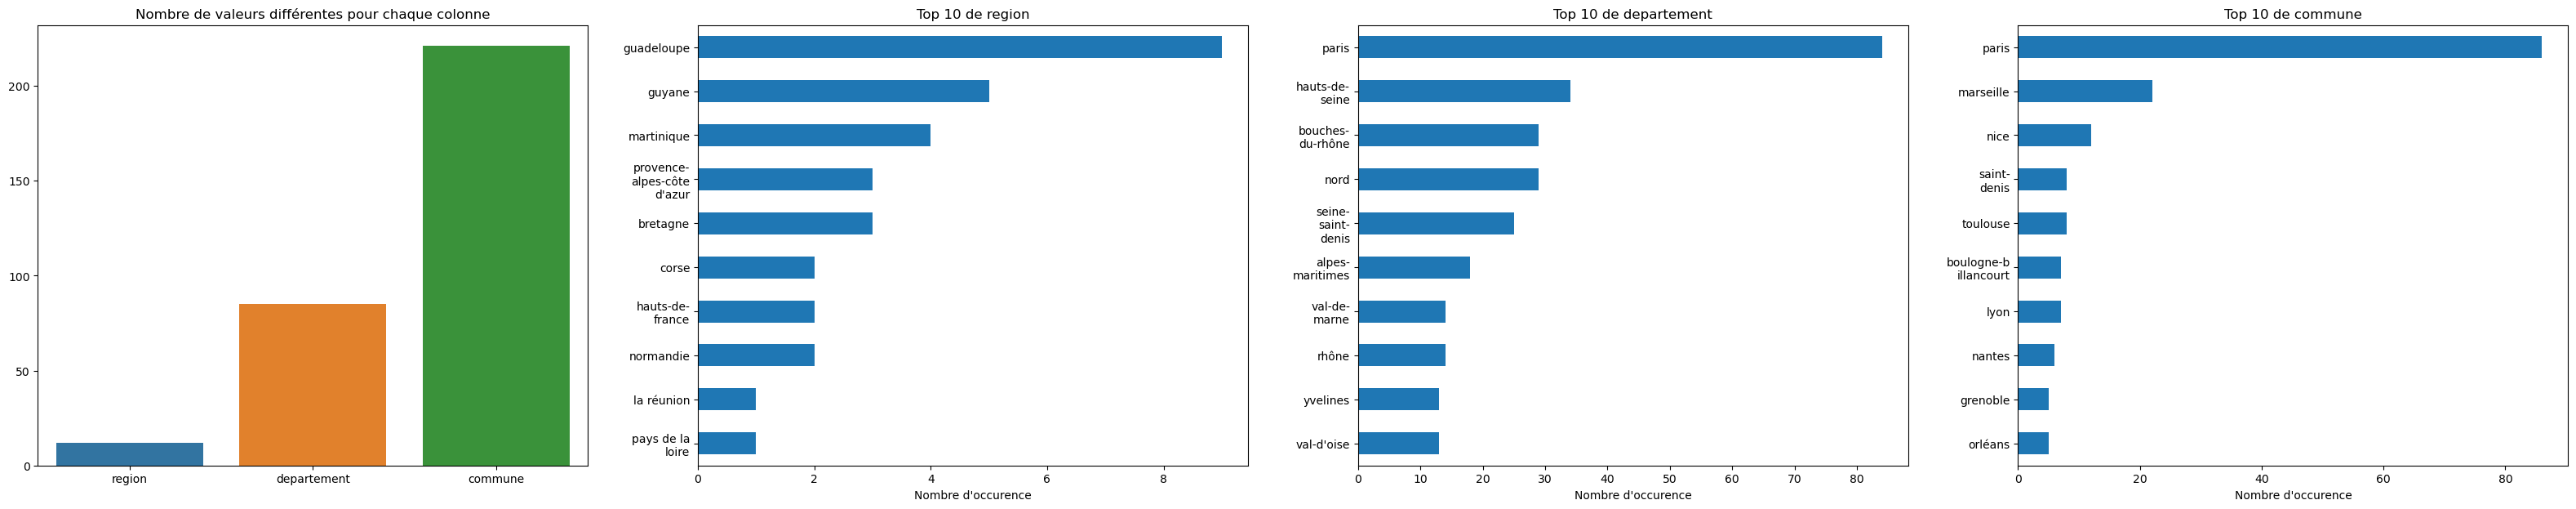

In [163]:
category_count(["region", "departement", "commune"], artists, top=10)

In [164]:
#Permet de récupérer la région à partir du département
def departement_to_region(x : str):
    value = commune.loc[commune["nom_departement"] == x, "nom_region"].values
    if len(value) > 0:
        return value[0]
    else:
        return np.NaN

In [165]:
#On ajoute les regions pour les departements
artists.loc[(~artists["departement"].isna()) & (artists["region"].isna()), "region"] = artists.loc[(~artists["departement"].isna()) & (artists["region"].isna()), "departement"].apply(departement_to_region)

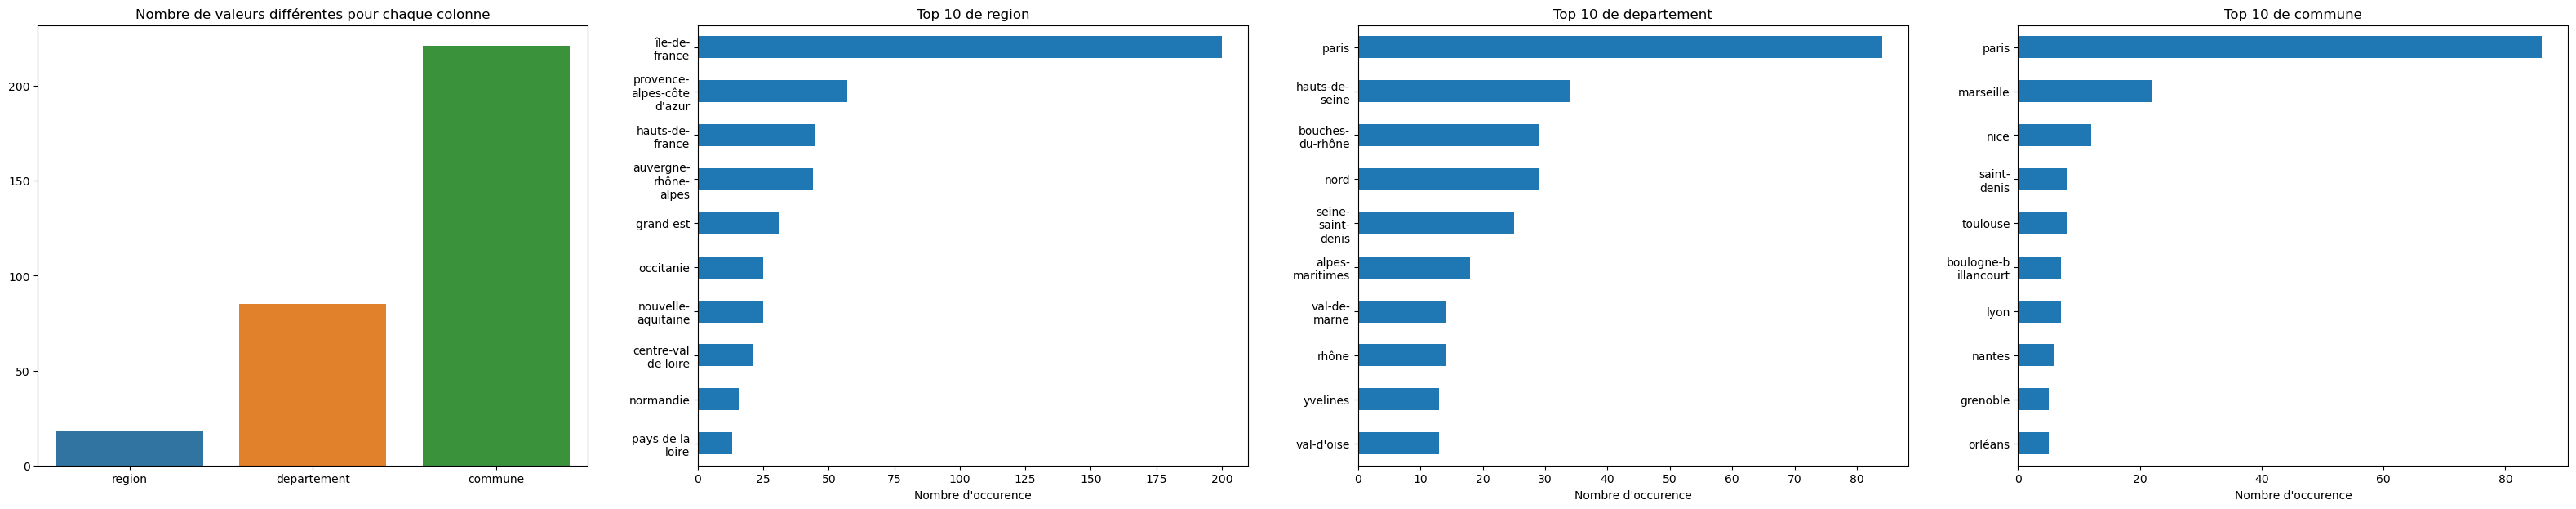

In [166]:
category_count(["region", "departement", "commune"], artists, top=10)

In [167]:
charts_c = charts.copy().merge(artists, left_on="artist", right_on="name", how="left").drop(columns=["rank","annee", "mois"]).drop_duplicates()

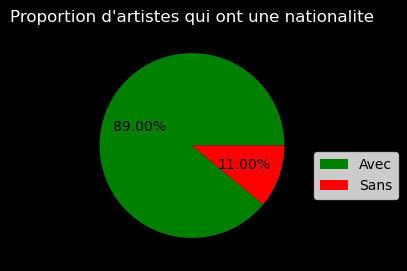

In [168]:
pie_chart(artists, "nationalite", "Proportion d'artistes qui ont une nationalite", True, ["Avec", "Sans"])

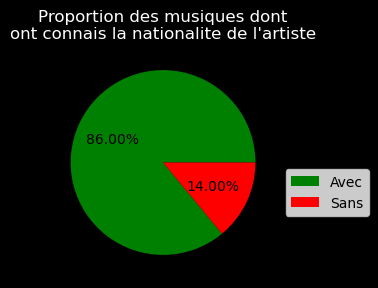

In [169]:
pie_chart(charts_c, "nationalite", "Proportion des musiques dont\nont connais la nationalite de l'artiste", True, ["Avec", "Sans"])

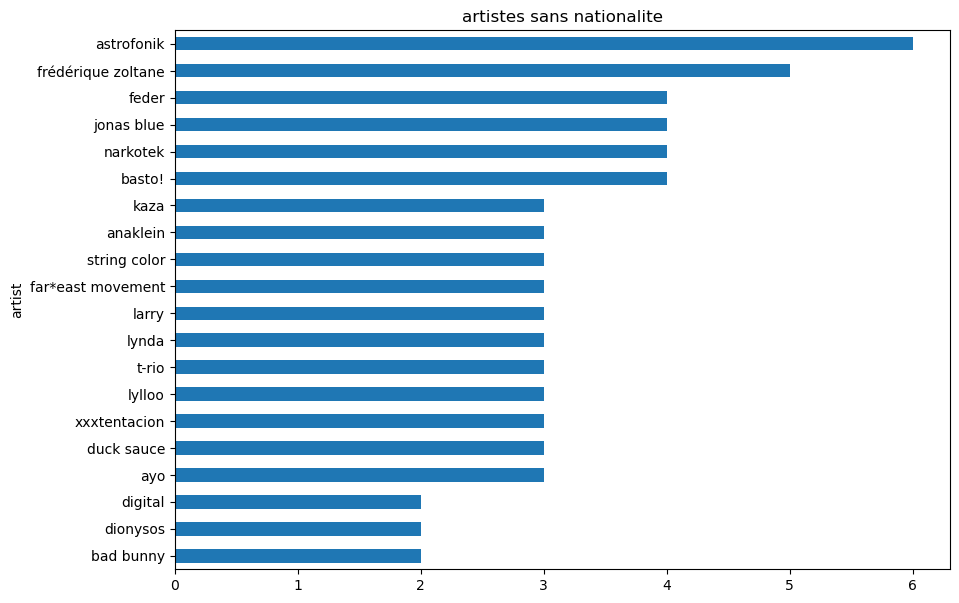

In [170]:
charts_c[charts_c["nationalite"].isna()].groupby("artist")["music"].count().sort_values()[-20:].plot.barh(figsize=(10,7))
plt.title("artistes sans nationalite")
plt.show()

In [171]:
artists.drop(columns=['no data', "no nationalite", "no localisation"], inplace=True)

In [172]:
artists = artists_org[["name"]].merge(artists, on="name", how="left")

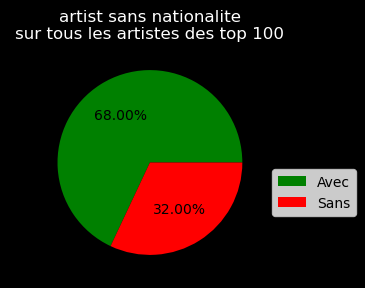

In [173]:
pie_chart(artists, "nationalite", "artist sans nationalite\nsur tous les artistes des top 100", True, ["Avec", "Sans"])

In [98]:
#Export
artists.to_csv(f"{etapes_path}cleanning wikipedia results/departement_region/artists.csv", encoding="utf-8-sig", index=False)

## C - Cleanning naissance

In [97]:
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/departement_region/artists.csv", encoding="utf-8-sig")

In [176]:
# On enleve le 'er' comme dans "1er"
artists["naissance"] = artists["naissance"].str.replace("er", "")

In [177]:
# On récupére les dates de naissanes normales
artists[["jour", "mois", "annee"]] = artists["naissance"].apply(extraire_date).apply(pd.Series).rename(columns={0: "jour", 1: "mois", 2: "annee"})

In [178]:
# On récupère les dates de naissances qui n'ont que l'année
artists.loc[artists["naissance"].str.contains(r"^[0-9]{4}", na=False), "annee"] = artists.loc[artists["naissance"].str.contains(r"^[0-9]{4}", na=False), "naissance"].str.extract(r"([0-9]{4})").values

In [179]:
# On récupère les dates de naissances qui n'ont que le mois et l'année
artists.loc[artists.naissance.str.contains(r"^(\w+)\s+(\d{4})", na=False), ["mois", "annee"]] = artists.loc[artists.naissance.str.contains(r"^(\w+)\s+(\d{4})", na=False), "naissance"].str.extract(r"^(\w+)\s+(\d{4})").values

C:\Users\quent\AppData\Local\Temp\ipykernel_11176\1702278564.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artists.loc[artists.naissance.str.contains(r"^(\w+)\s+(\d{4})", na=False), ["mois", "annee"]] = artists.loc[artists.naissance.str.contains(r"^(\w+)\s+(\d{4})", na=False), "naissance"].str.extract(r"^(\w+)\s+(\d{4})").values
C:\Users\quent\AppData\Local\Temp\ipykernel_11176\1702278564.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artists.loc[artists.naissance.str.contains(r"^(\w+)\s+(\d{4})", na=False), ["mois", "annee"]] = artists.loc[artists.naissance.str.contains(r"^(\w+)\s+(\d{4})", na=False), "naissance"].str.extract(r"^(\w+)\s+(\d{4})").values


In [180]:
artists.to_csv(f"{etapes_path}cleanning naissance/artists.csv", encoding="utf-8-sig", index=False)

## D - Ajout de l'id_artist

In [375]:
artists = pd.read_csv(f"{etapes_path}cleanning naissance/artists.csv", encoding="utf-8-sig")
charts = pd.read_csv(f"{etapes_path}cleanning chart/charts.csv", encoding="utf-8-sig")

In [376]:
# Ajout de l'id
artists = add_id(artists, ["name"], "id_artist")

In [378]:
# On remplace le nom des artistes par leur id dans le charts et on renome le nom de la colonne
charts["artist"] = charts["artist"].apply(lambda x : artists[artists["name"] == x]["id_artist"].values[0])
charts.rename(columns={"artist" : "id_artist"}, inplace=True)

In [379]:
charts.to_csv(f"{etapes_path}cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig", index=False)
artists.to_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig", index=False)

## E - Analyse

In [103]:
#Import
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig")
charts = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig")

### 1 - Maps

In [218]:
departement_df = gpd.read_file("../../shapefile/departement/georef-france-departement-millesime.shp", encoding="utf-8")

In [219]:
region_df = gpd.read_file("../../shapefile/region/regions-20180101.shp")

In [220]:
nom_to_suppr = ["Guyane", "La Réunion", "Corse", "Martinique", "Guadeloupe", "Mayote"]
region_df = region_df[~region_df["nom"].isin(nom_to_suppr)]

In [221]:
#Remove overseas departments
idx = []
for dp in ["971", "972", "973", "974", "976"]:
    idx += departement_df[departement_df["dep_code"] == dp].index.tolist()
departement_df.drop(index=idx, inplace=True)

In [222]:
departement_map = departement_df[["dep_name_lo", "geometry"]].copy()
region_map = region_df[["nom", "geometry"]].copy()

In [223]:
region_map["nom"] = region_map["nom"].str.lower()

In [224]:
departement_count = artists.copy().groupby("departement")["wiki name"].count()
region_count = artists.copy().groupby("region")["wiki name"].count()

In [225]:
departement_count = pd.DataFrame(departement_count).merge(departement_map, left_on="departement", right_on="dep_name_lo", how="left")
region_count = pd.DataFrame(region_count).merge(region_map, left_on="region", right_on="nom", how="left")

In [226]:
departement_count = gpd.GeoDataFrame(departement_count, geometry="geometry")
region_count = gpd.GeoDataFrame(region_count, geometry="geometry")

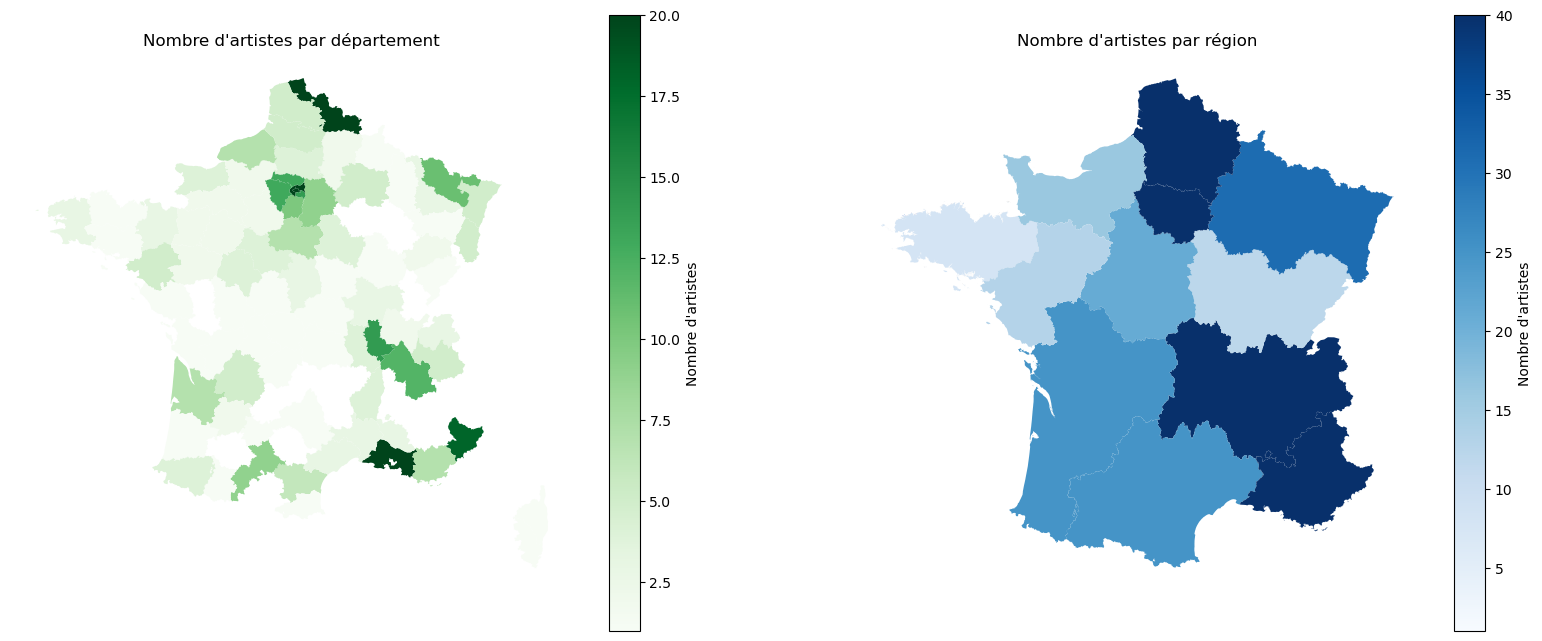

In [227]:
#Plot departement and region on map
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
departement_count.plot(column="wiki name", ax=ax[0], legend=True, legend_kwds={'label': "Nombre d'artistes"}, vmax=20, cmap="Greens")
region_count.plot(column="wiki name", ax=ax[1], legend=True, legend_kwds={'label': "Nombre d'artistes"}, vmax=40, cmap="Blues")
ax[0].set_title("Nombre d'artistes par département")
ax[0].axis("off")
ax[1].set_title("Nombre d'artistes par région")
ax[1].axis("off")
plt.show()

### 2 - Naissance

In [228]:
artists["annee"].value_counts()

1981.0    43
1991.0    40
1987.0    39
1989.0    39
1984.0    39
          ..
1954.0     1
1928.0     1
1046.0     1
1926.0     1
1935.0     1
Name: annee, Length: 81, dtype: int64

In [229]:
artists["mois"].value_counts()

mai          114
septembre    105
janvi         97
juillet       93
novembre      89
décembre      88
juin          82
mars          79
févri         78
octobre       75
août          75
avril         72
Name: mois, dtype: int64

In [230]:
artists["jour"].value_counts()

15.0    45
3.0     42
14.0    41
26.0    40
13.0    40
19.0    40
5.0     40
2.0     39
10.0    37
20.0    36
21.0    36
4.0     35
16.0    35
29.0    35
25.0    35
1.0     35
18.0    33
23.0    33
22.0    33
17.0    33
24.0    32
9.0     31
12.0    31
7.0     31
28.0    31
27.0    28
6.0     28
30.0    27
8.0     26
11.0    26
31.0    11
Name: jour, dtype: int64

# Scrapping parole

## A - Code

In [382]:
#Import
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig")
charts = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig")

In [232]:
musics = charts.copy()[["id_music", "id_artist", "music"]].drop_duplicates()
musics = musics.merge(artists[["id_artist", "name"]], on="id_artist", how="left").rename(columns={"name" : "artist"})

In [233]:
musics["lyrics"] = musics.apply(find_lyrics, axis=1)

In [234]:
musics.drop(columns=["artist"], inplace=True)
charts.drop(columns=["music", "id_artist"], inplace=True)

In [388]:
#export
musics.to_csv(f"{etapes_path}scrapping lyrics/musics.csv", encoding="utf-8-sig", index=False)
charts.to_csv(f"{etapes_path}scrapping lyrics/charts.csv", encoding="utf-8-sig", index=False)

## B - Analyse

In [389]:
#import
musics = pd.read_csv(f"{etapes_path}scrapping lyrics/musics.csv", encoding="utf-8-sig")
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig")

In [237]:
data = musics.merge(artists[["id_artist", "name"]], on="id_artist", how="left")
data.rename(columns={"name":"artist"}, inplace=True)

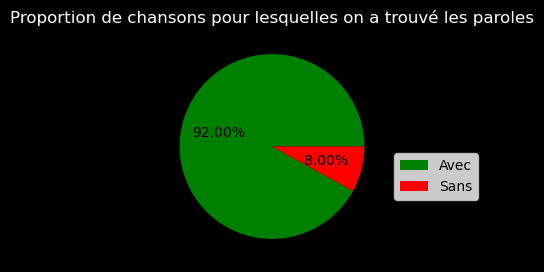

In [238]:
pie_chart(data, "lyrics", "Proportion de chansons pour lesquelles on a trouvé les paroles", True, ["Avec", "Sans"])

# Cleaning lyrics

## A - Cleaning

In [239]:
#import
musics = pd.read_csv(f"{etapes_path}scrapping lyrics/musics.csv", encoding="utf-8-sig")

In [240]:
musics["lyrics"] = musics.apply(cleanning_lyrics, axis=1)

In [241]:
#export
musics.to_csv(f"{etapes_path}cleaning lyrics/musics.csv", encoding="utf-8-sig", index=False)

## B - Analyse

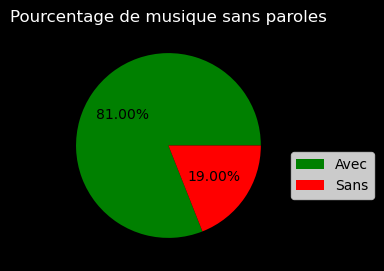

In [242]:
pie_chart(musics, "lyrics", "Pourcentage de musique sans paroles", True, ["Avec", "Sans"])

# Add features

## 1 - Code

In [243]:
#import
musics = pd.read_csv(f"{etapes_path}cleaning lyrics/musics.csv", encoding="utf-8-sig")
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig")

In [244]:
musics = musics.merge(artists[["id_artist", "name"]], on="id_artist", how="left")
musics.rename(columns={"name" : "artist"}, inplace=True)

In [245]:
features = musics.apply(get_features, axis=1)

In [246]:
columns = [
    "danceability",         # Dacilité à danser sur une chanson, allant de 0.0 (pas de rythme) à 1.0 (rythme très fort)
    "energy",               # Energie d'une chanson, allant de 0.0 (très calme) à 1.0 (très énergique)
    "key",                  # Tonalité de la chanson, allant de 0 à 11
    "loudness",             # Niveau sonore d'une chanson, en décibels (dB)
    "mode",                 # Indique si la chanson est en mode majeur (1) ou mineur (0)
    "speechiness",          # Pourcentage de parole dans une chanson, allant de 0.0 (pas de parole) à 1.0 (discours)
    "acousticness",         # Acousticité d'une chanson, allant de 0.0 (fortement électronique) à 1.0 (complètement acoustique)
    "instrumentalness",     # Présence d'instruments par rapport à la voix, allant de 0.0 (beaucoup de voix) à 1.0 (complètement instrumental)
    "liveness",             # Présence d'un public dans l'enregistrement, allant de 0.0 (enregistrement en studio) à 1.0 (enregistrement en direct)
    "valence",              # Humeur positive ou négative d'une chanson, allant de 0.0 (très négative) à 1.0 (très positive)
    "tempo",                # Rythme d'une chanson en battements par minute (BPM)
    "duration_ms",          # Durée d'une chanson en millisecondes
    "time_signature"        # Nombre de temps dans une mesure musicale, souvent exprimé sous la forme d'un nombre entier (par exemple, 4 pour 4/4)
]

In [247]:
features_df = pd.DataFrame(features.tolist(), columns=columns)

In [248]:
musics = musics.merge(features_df, left_index=True, right_index=True)

In [249]:
musics.drop(columns=["artist"], inplace=True)

In [250]:
musics.to_csv(f"{etapes_path}add features/musics.csv", encoding="utf-8-sig", index=False)

## 2 - Analyse

In [251]:
musics = pd.read_csv(f"{etapes_path}add features/musics.csv", encoding="utf-8-sig")

In [252]:
columns = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

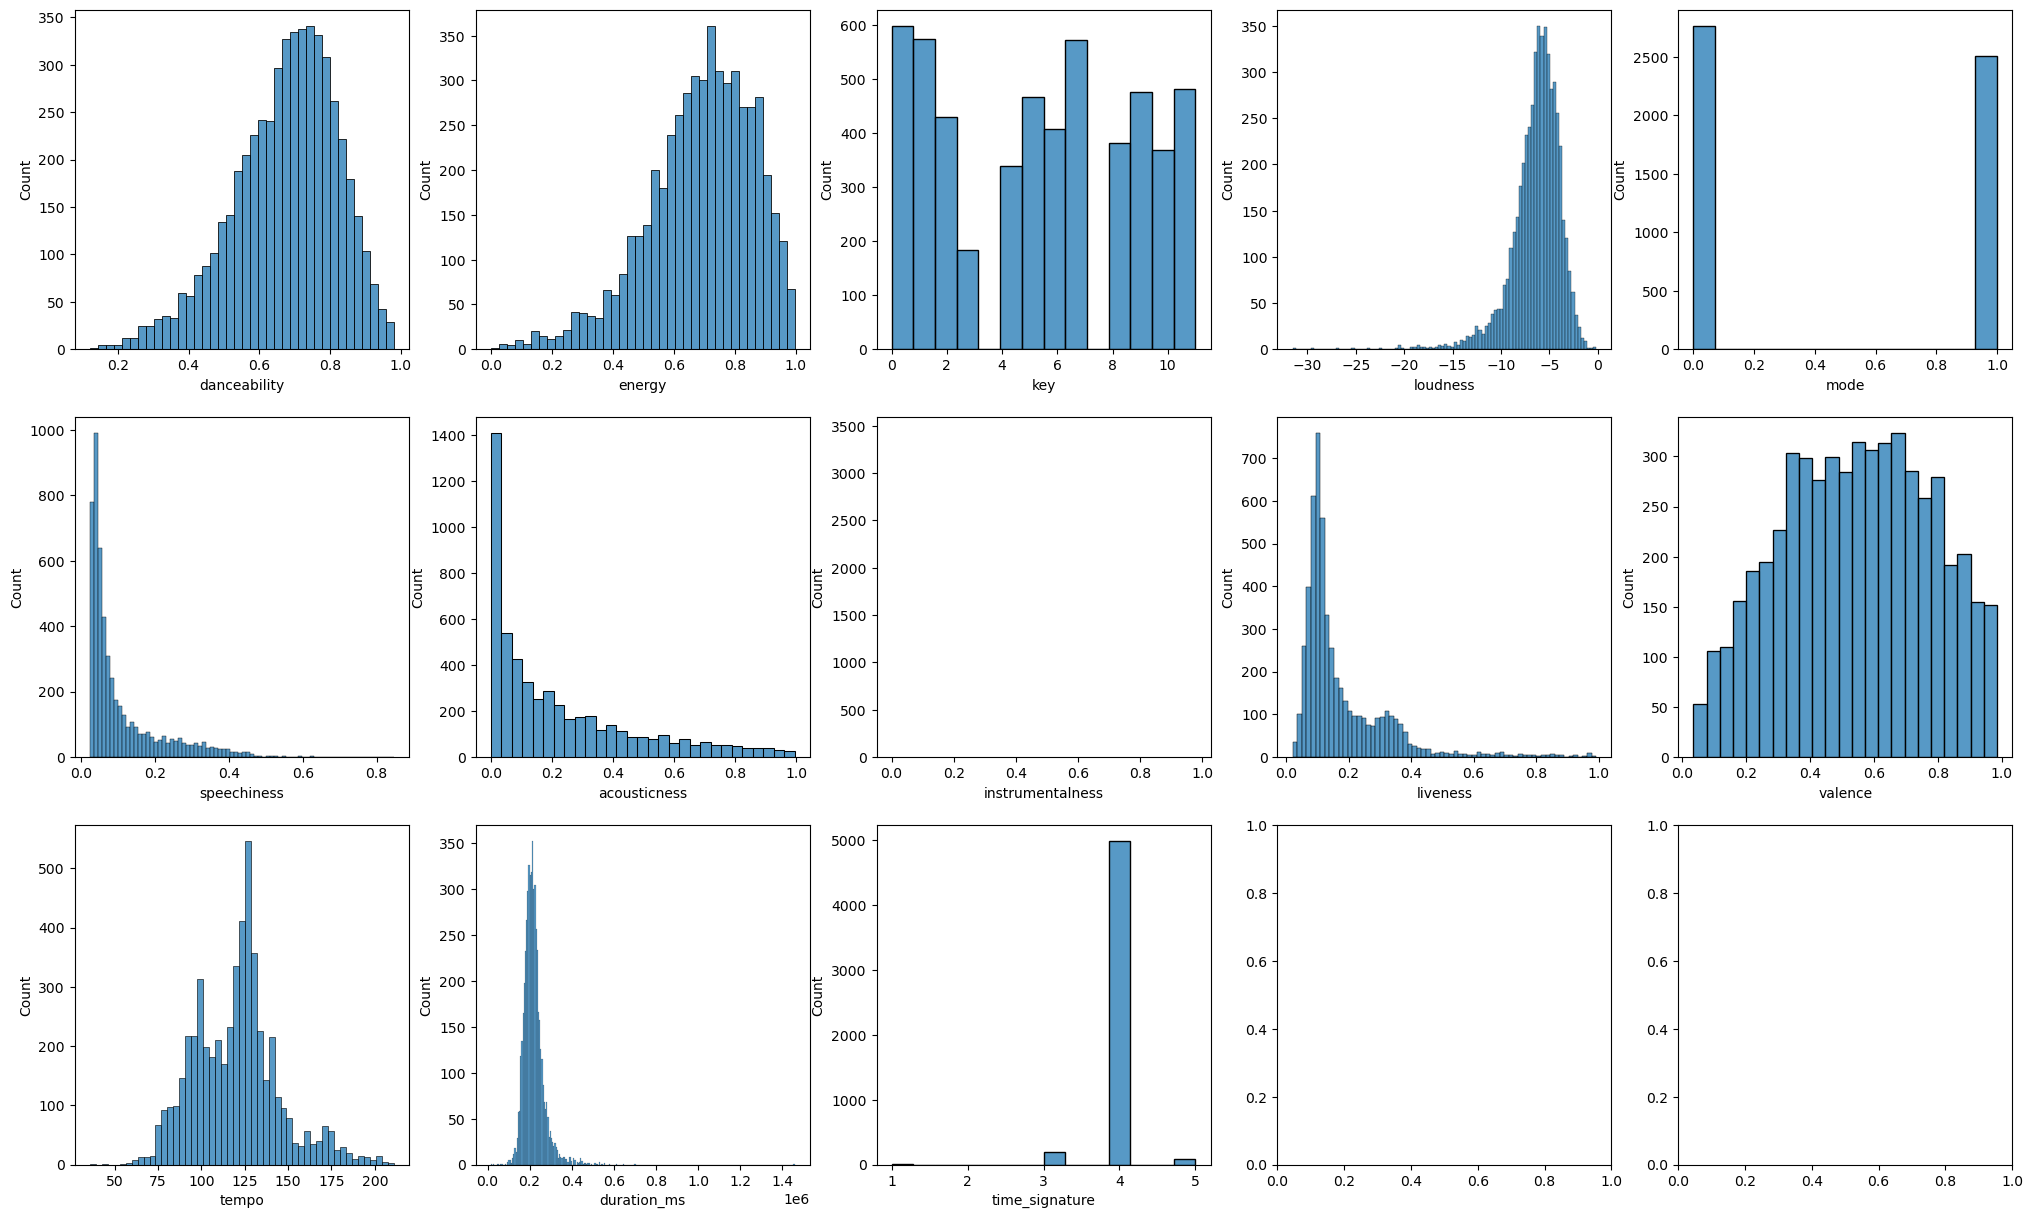

In [253]:
fig, axis = plt.subplots(int(np.ceil(len(columns)/5)), 5, figsize=(25,15))

for col, ax in zip(columns, axis.flatten()):
    sns.histplot(musics[col], ax=ax)

In [254]:
corr_mat = musics[columns].corr()

for elem in [(i,i) for i in range(len(columns))]:
    corr_mat.values[elem] = np.nan

<AxesSubplot: >

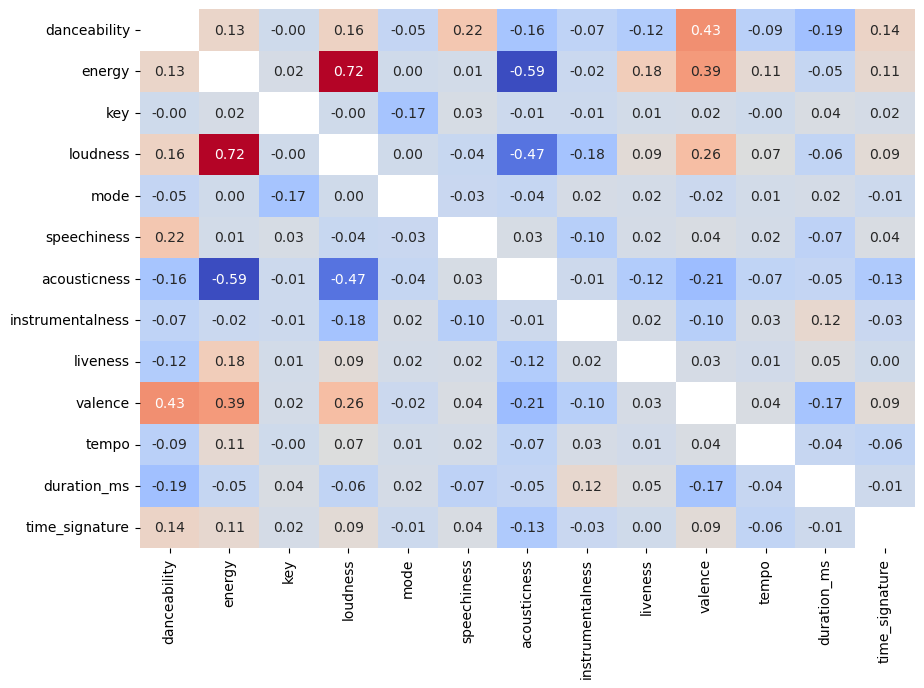

In [255]:
plt.figure(figsize=(10,7))
sns.heatmap(corr_mat, cbar=False, annot=True, fmt=".2f", cmap="coolwarm")

# Clustering

## A - Keep francophone musics

### 1 - Code

In [256]:
#import
musics = pd.read_csv(f"{etapes_path}add features/musics.csv", encoding="utf-8-sig")

In [257]:
musics["lang"] = musics["lyrics"].apply(lambda x : detect(x) if not x is np.NaN else np.NaN)

In [258]:
musics["is french"] = musics["lang"] == "fr"

In [259]:
#export
musics.to_csv(f"{etapes_path}clustering/isFrench/musics.csv", encoding="utf-8-sig", index=False)

### 2 - Analyse

In [266]:
musics = pd.read_csv(f"{etapes_path}clustering/isFrench/musics.csv", encoding="utf-8-sig")
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig")

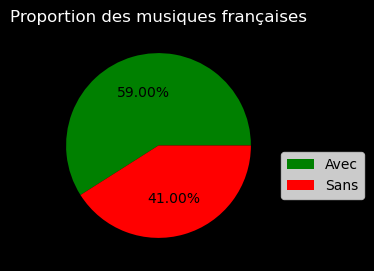

In [267]:
pie_chart(musics, "is french", "Proportion des musiques françaises", False, ["Avec", "Sans"])

In [268]:
artists.head()

,name,wiki name,naissance,pays d'origine,origine,nationalite,pays,summary,region,commune,departement,jour,mois,annee,id_artist
0,tragedie,Tragédie (groupe),NaN,france,NaN,français,france,tragédie est un groupe de rnb et de hip-hop fr...,pays de la loire,nantes,loire-atlantique,NaN,NaN,NaN,0
1,star academy,Star Academy (France),NaN,NaN,NaN,français,france,star academy est une émission de télévision fr...,NaN,NaN,NaN,NaN,NaN,NaN,1
2,lorie pester,Lorie Pester,"2 mai 1982 (40 ans)le plessis-bouchard, val-d'...",NaN,NaN,français,france,"laure pester, ou simplement lorie, née le 2 ma...",île-de-france,le plessis-bouchard,val-d'oise,2.0,mai,1982.0,2
3,hélène segara,Hélène Ségara,26 févri 1971 (51 ans)six-fours-les-plages (fr...,NaN,NaN,français,NaN,"hélène ségara, de son vrai nom hélène rizzo, e...",provence-alpes-côte d'azur,la seyne-sur-mer,var,26.0,févri,1971.0,3
4,kareen antonn,Kareen Antonn,"24 mai 1980 (42 ans)nogent-sur-marne, (val-de-...",NaN,NaN,français,france,"kareen antonn, de son vrai nom kareen antonopo...",île-de-france,nogent-sur-marne,val-de-marne,24.0,mai,1980.0,4


In [269]:
musics = musics[musics["is french"]]
musics = musics.merge(artists[["id_artist", "name", "nationalite", "region", "commune", "departement"]], on="id_artist", how="left").rename(columns={"name" : "artist"})

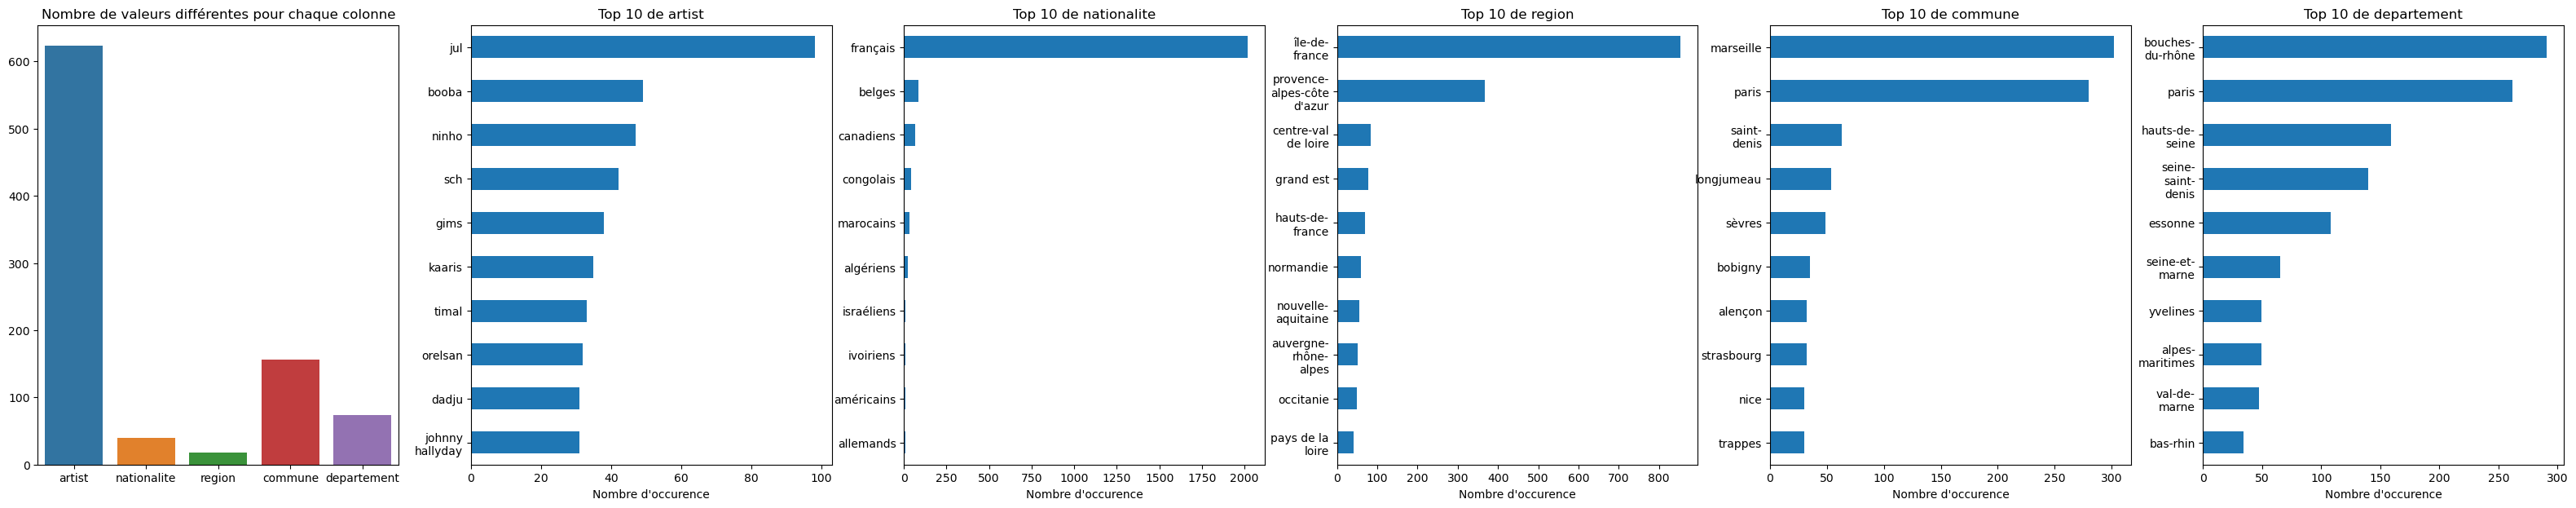

In [270]:
category_count(["artist", "nationalite", "region", "commune", "departement"], musics)

## B - TF-IDF

In [271]:
#import
musics = pd.read_csv(f"{etapes_path}clustering/isFrench/musics.csv", encoding="utf-8-sig")
charts = pd.read_csv(f"{etapes_path}scrapping lyrics/charts.csv", encoding="utf-8-sig")

In [272]:
nlp = spacy.load("fr_core_news_sm")
nlp.max_length = 3_000_000

In [273]:
# Lyrics concatenation by a column
def lyrics_by(data, by, nlp):
    lyrics = data.groupby(by)["lyrics"].apply(lambda x : " ".join(x.to_list()))
    lyrics = lyrics.apply(lambda x : lematization(x, nlp))
    return lyrics

In [274]:
def tfidf_by(data, by, nlp):
    lyrics = lyrics_by(data, by, nlp)
    index = lyrics.index.to_list()
    tfidf = tfidf_mat(lyrics)
    tfidf.index = index
    return tfidf

In [275]:
# Prepare data
musics = musics[musics["is french"]]
musics = musics.merge(charts[["id_music", "annee"]], on="id_music", how="left")

In [276]:
by_list = ["id_artist", "id_music", "annee"]

# Compute tfidf
for by in by_list:
    tfidf = tfidf_by(musics, by, nlp)
    tfidf.to_csv(f"{etapes_path}clustering/tfidf/tfidf_{by}.csv", encoding="utf-8-sig")

## C - Clustering

In [390]:
#import
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig")
musics = pd.read_csv(f"{etapes_path}clustering/isFrench/musics.csv", encoding="utf-8-sig")
charts = pd.read_csv(f"{etapes_path}scrapping lyrics/charts.csv", encoding="utf-8-sig")

In [3]:
musics = musics[musics["is french"]].copy()

In [4]:
tfidf = pd.read_csv(f"{etapes_path}clustering/tfidf/tfidf_id_artists.csv", encoding="utf-8-sig", index_col=0)

In [50]:
by_list = ["id_artist", "id_music", "annee"]
ddgms = {}
# Compute clustering
for ax, by in tqdm(zip(axis, by_list)):
    tfidf = pd.read_csv(f"{etapes_path}clustering/tfidf/tfidf_{by}.csv", encoding="utf-8-sig", index_col=0)
    Z = linkage(tfidf, method="ward", metric="euclidean")
    ddgms[by] = {"Z" : Z, "tfidf" : tfidf}

3it [01:46, 35.64s/it]


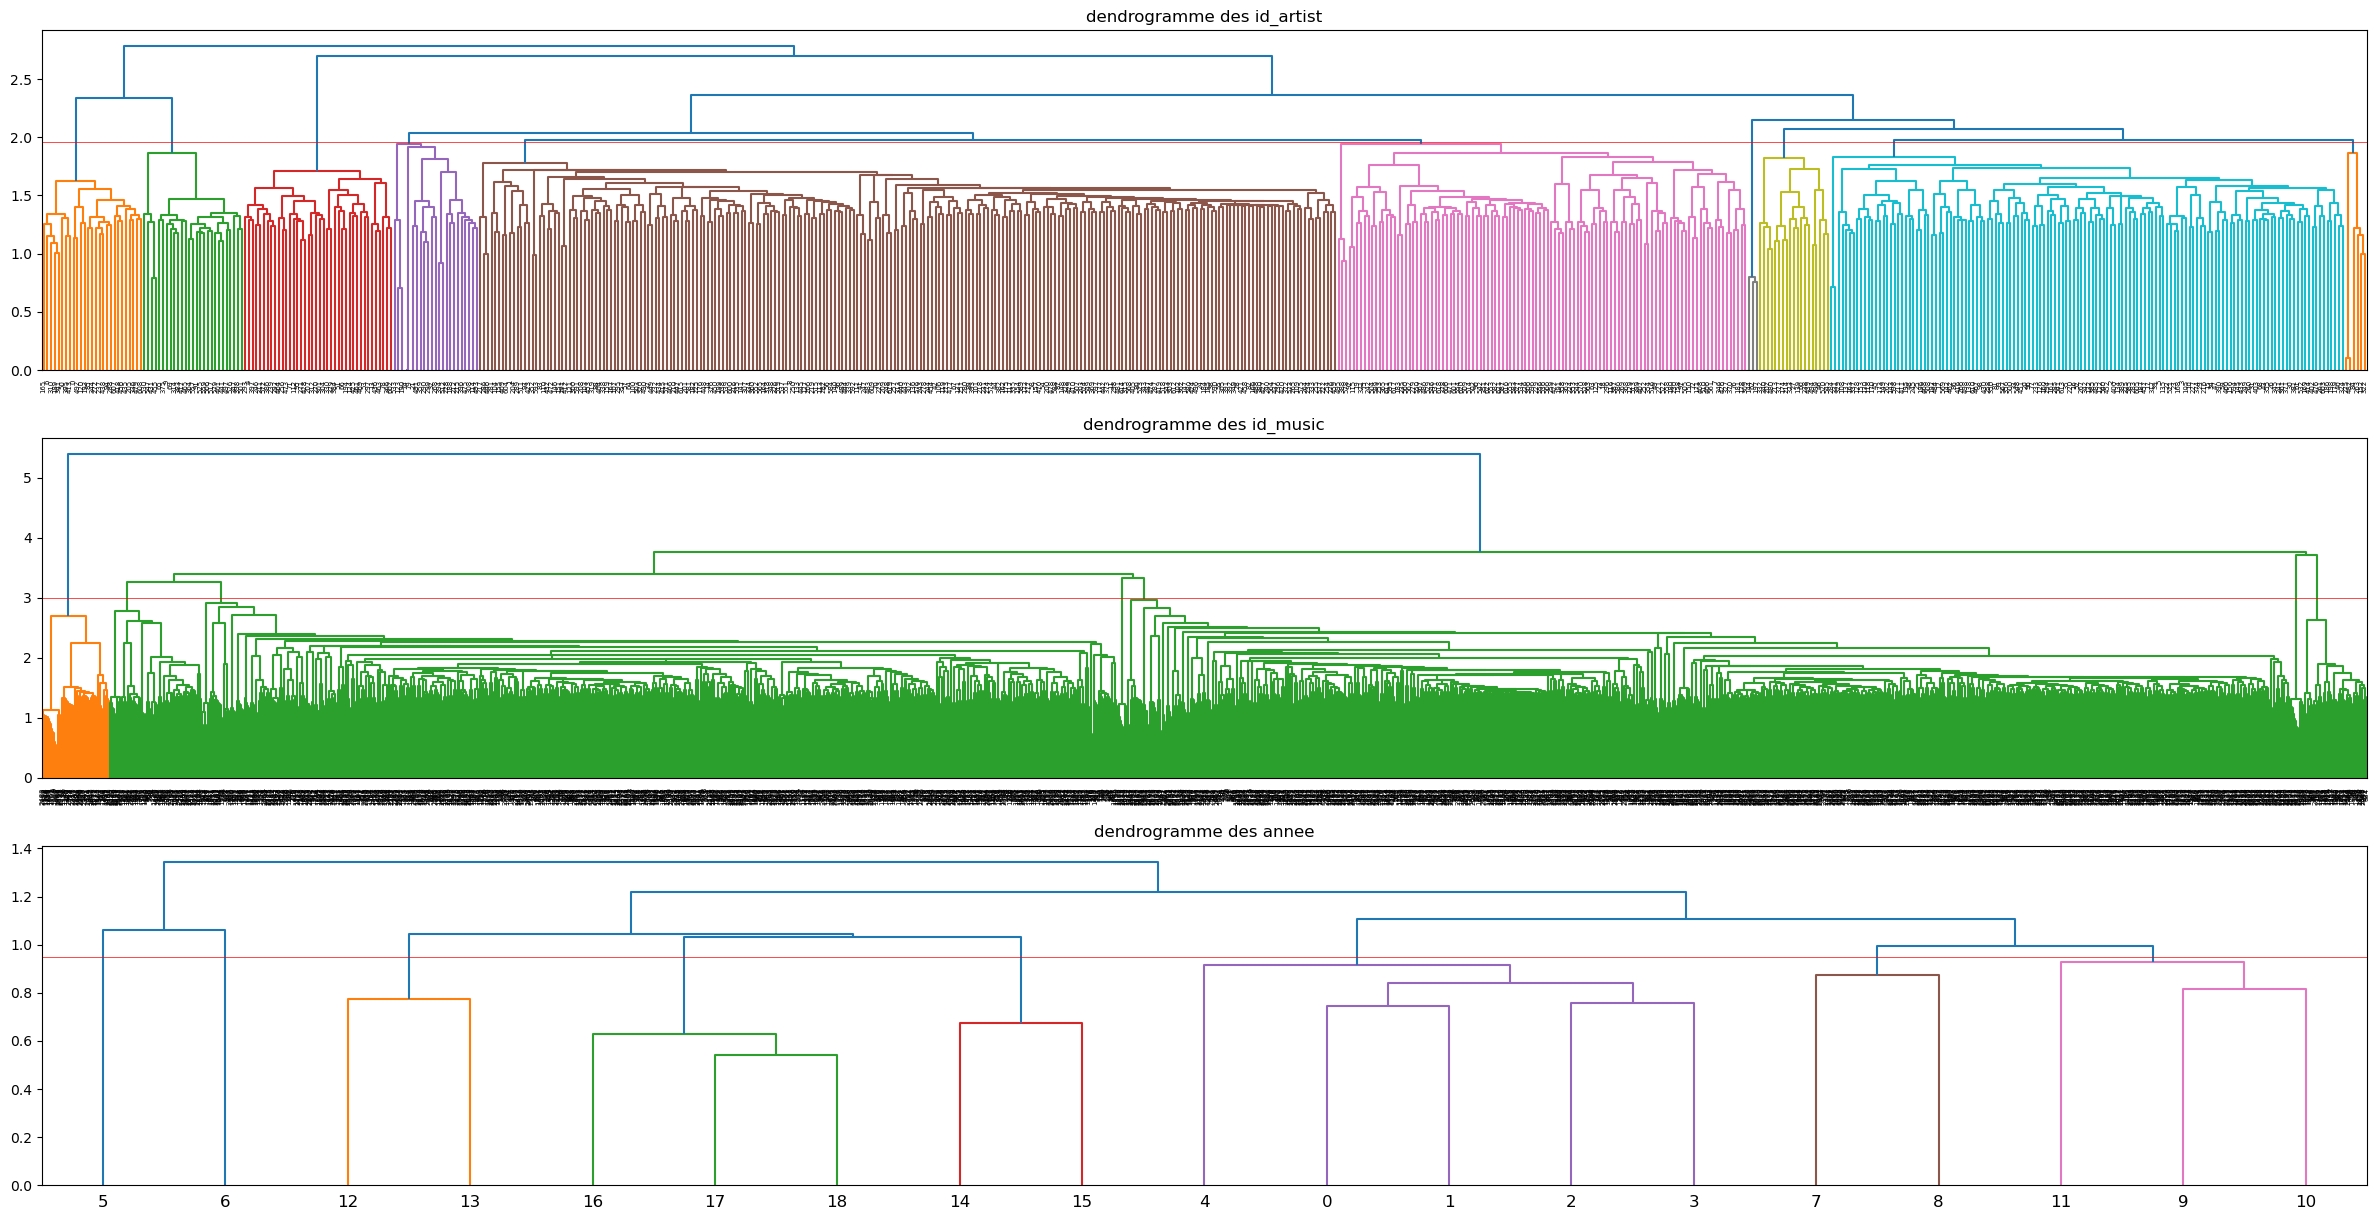

In [52]:
fig, axis = plt.subplots(3, 1, figsize=(30,15))
cut_lines = [1.96, 3, 0.95]
data = []

for ax, by, cut_line in zip(axis, by_list, cut_lines):
    clusters = fcluster(ddgms[by]["Z"], cut_line, criterion="distance")
    data.append(pd.DataFrame({f"{by}" : ddgms[by]["tfidf"].index, "cluster" : clusters}))

    dendrogram(ddgms[by]["Z"], ax=ax)
    ax.hlines(y=cut_line, xmin=0, xmax=10**5, colors="r", linewidth=0.5)
    ax.set_title(f"dendrogramme des {by}")

plt.show()

In [81]:
artists = data[0].merge(artists, on="id_artist", how="left")
musics = data[1].merge(musics, on="id_music", how="left")
charts = data[2].merge(charts, on="annee", how="right")

In [82]:
artists.to_csv(f"{etapes_path}clustering/cluster/artists.csv", encoding="utf-8-sig", index=False)
musics.to_csv(f"{etapes_path}clustering/cluster/musics.csv", encoding="utf-8-sig", index=False)
charts.to_csv(f"{etapes_path}clustering/cluster/charts.csv", encoding="utf-8-sig", index=False)

# bag of words

## A - Code

In [104]:
#import
musics = pd.read_csv(f"{etapes_path}clustering/cluster/musics.csv", encoding="utf-8-sig")

In [105]:
musics = musics[musics["is french"]]

In [106]:
nlp = spacy.load("fr_core_news_sm")

In [107]:
stopwords = nlp.Defaults.stop_words
sw_to_add = [" ", "-", ',', '{', ':}', '}', '...', ':', '?', "'", '"', '\u2005', '\u205f', "!", "j", "y'", "faire", "aller"]
for sw in sw_to_add:
    stopwords.add(sw)

In [108]:
bag_of_words = musics["lyrics"].apply(lambda x : bag_of_words(x, nlp, stopwords))
bag_of_words = dict(bag_of_words)

In [109]:
data = []
for id in bag_of_words.keys():
    for mot, nb in bag_of_words[id].items():
        data.append([id, mot, nb])

In [110]:
bag_of_words = pd.DataFrame(data, columns=["id_music", "mot", "nb"])

In [111]:
musics.to_csv(f"{etapes_path}bag of words/musics.csv", index=False, encoding="utf-8-sig")
bag_of_words.to_csv(f"{etapes_path}bag of words/bag_of_words.csv", index=False)

## B - Analysis

In [344]:
#import
musics = pd.read_csv(f"{etapes_path}bag of words/musics.csv")
charts = pd.read_csv(f"{etapes_path}clustering/cluster/charts.csv", encoding="utf-8-sig")
artists = pd.read_csv(f"{etapes_path}clustering/cluster/artists.csv", encoding="utf-8-sig")
bag_of_words = pd.read_csv(f"{etapes_path}bag of words/bag_of_words.csv")

In [345]:
# import data on lands on clean it
pays_continents = pd.read_excel("../../monde/pays_continent.xlsx", sheet_name="nat_cont").replace("-", np.nan).dropna()
for col in pays_continents.columns:
    pays_continents[col] = pays_continents[col].astype(str)
    pays_continents[col] = pays_continents[col].str.lower()

In [346]:
# create dict to map nationalities to lands
code = {"britannique (ru)" : "britanniques"}
nats = artists["nationalite"].unique().tolist()
nats.remove(np.nan)

for nat in pays_continents["nationalite"].unique():
    for n in nats:
        if (edit_distance(nat, n)/len(n)) < 0.3:
            code[nat] = n
            break

pays_continents["nationalite"] = pays_continents["nationalite"].map(code)
pays_continents = pd.concat([pays_continents, pd.DataFrame([["guyanais", "guyanais", "amérique du sud"]], columns=pays_continents.columns)], ignore_index=True)

In [357]:
bow_charts = bag_of_words.merge(charts, on="id_music", how="left").rename(columns={"cluster" : "cluster_charts"})

In [358]:
bow_charts

,id_music,mot,nb,annee,cluster_charts,mois,rank,artist,music
0,0,yeah,3,2004,6,janvier,1,tragedie,sexy pour moi
1,0,yeah,3,2004,6,fevrier,5,tragedie,sexy pour moi
2,0,yeah,3,2004,6,mars,24,tragedie,sexy pour moi
3,0,yeah,3,2004,6,avril,66,tragedie,sexy pour moi
4,0,tizy,1,2004,6,janvier,1,tragedie,sexy pour moi
...,...,...,...,...,...,...,...,...,...
1092064,2527,traîne,1,2012,7,juillet,4,pitbull,back in time
1092065,2527,traîne,1,2012,7,aout,6,pitbull,back in time
1092066,2527,traîne,1,2012,7,septembre,40,pitbull,back in time
1092067,2527,traîne,1,2012,7,octobre,67,pitbull,back in time


In [355]:
bow_charts

,id_music,mot,nb,annee,cluster_charts,mois,rank,artist,music
0,0,yeah,3,2004,6,janvier,1,tragedie,sexy pour moi
1,0,yeah,3,2004,6,fevrier,5,tragedie,sexy pour moi
2,0,yeah,3,2004,6,mars,24,tragedie,sexy pour moi
3,0,yeah,3,2004,6,avril,66,tragedie,sexy pour moi
4,0,tizy,1,2004,6,janvier,1,tragedie,sexy pour moi
...,...,...,...,...,...,...,...,...,...
1092064,2527,traîne,1,2012,7,juillet,4,pitbull,back in time
1092065,2527,traîne,1,2012,7,aout,6,pitbull,back in time
1092066,2527,traîne,1,2012,7,septembre,40,pitbull,back in time
1092067,2527,traîne,1,2012,7,octobre,67,pitbull,back in time


In [354]:
musics[["id_music", "id_artist", "cluster"]]

,id_music,id_artist,cluster
0,0,0,5
1,3,3,3
2,4,4,7
3,8,7,3
4,9,8,1
...,...,...,...
2523,6227,2202,5
2524,6228,1940,5
2525,6230,1765,1
2526,6231,2118,6


In [351]:
bow_charts.merge(musics[["id_music", "id_artist", "cluster"]], on="id_music", how="left").rename(columns={"cluster" : "cluster_musics"})

,id_music,mot,nb,annee,cluster_charts,mois,rank,artist,music,id_artist,cluster_musics
0,0,yeah,3,2004,6,janvier,1,tragedie,sexy pour moi,0.0,5.0
1,0,yeah,3,2004,6,fevrier,5,tragedie,sexy pour moi,0.0,5.0
2,0,yeah,3,2004,6,mars,24,tragedie,sexy pour moi,0.0,5.0
3,0,yeah,3,2004,6,avril,66,tragedie,sexy pour moi,0.0,5.0
4,0,tizy,1,2004,6,janvier,1,tragedie,sexy pour moi,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
1092064,2527,traîne,1,2012,7,juillet,4,pitbull,back in time,NaN,NaN
1092065,2527,traîne,1,2012,7,aout,6,pitbull,back in time,NaN,NaN
1092066,2527,traîne,1,2012,7,septembre,40,pitbull,back in time,NaN,NaN
1092067,2527,traîne,1,2012,7,octobre,67,pitbull,back in time,NaN,NaN


In [350]:
bow_charts.isna().sum()

id_music            0
mot               646
nb                  0
annee               0
cluster_charts      0
mois                0
rank                0
artist              0
music               0
dtype: int64

In [343]:
bow_charts = bag_of_words.merge(charts, on="id_music", how="left").rename(columns={"cluster" : "cluster_charts"})
bow_charts = bow_charts.merge(musics[["id_music", "id_artist", "cluster"]], on="id_music", how="left").rename(columns={"cluster" : "cluster_musics"})
bow_charts = bow_charts.merge(artists[["id_artist", "nationalite", "region", "commune", "cluster"]], on="id_artist", how="left").rename(columns={"cluster" : "cluster_artists"})

In [285]:
bow_charts = bag_of_words.merge(charts, on="id_music", how="left").rename(columns={"cluster" : "cluster_charts"})
bow_charts = bow_charts.merge(musics[["id_music", "id_artist", "cluster"]], on="id_music", how="left").rename(columns={"cluster" : "cluster_musics"})
bow_charts = bow_charts.merge(artists[["id_artist", "nationalite", "region", "commune", "cluster"]], on="id_artist", how="left").rename(columns={"cluster" : "cluster_artists"})
bow_charts = bow_charts[~bow_charts.mot.isna() & ~bow_charts["id_artist"].isna()]

In [286]:
region_groups = {
    "île-de-france" : "Ile de France",
    "provence-alpes-côte d'azur" : "PACA",
    "grand est" : "EST",
    "bourgogne-franche-comté" : "EST",
    "hauts-de-france" : "EST",
    "normandie" : "OUEST",
    "bretagne" : "OUEST",
    "pays de la loire" : "OUEST",
    "centre-val de loire" : "OUEST",
    "auvergne-rhône-alpes" : "SUD",
    "occitanie" : "SUD",
    "nouvelle-aquitaine" : "SUD",
    "guadeloupe" : "DOMTOM",
    "la réunion" : "DOMTOM",
    "guyane" : "DOMTOM",
    "corse" : "DOMTOM",
    "martinique" : "DOMTOM"
}

bow_charts["region groups"] = bow_charts["region"].map(region_groups)

In [287]:
def get_continent(nat):
    if nat in pays_continents["nationalite"].unique():
        return pays_continents[pays_continents["nationalite"] == nat]["continent"].values[0]
    else:
        return np.nan

bow_charts["continent"] = bow_charts["nationalite"].apply(get_continent)

In [288]:
def plot_compare_words(df, nb_rows, nb_cols, figsize=(30,10)):
    fig, ax = plt.subplots(nb_rows, nb_cols, figsize=figsize)

    for col, ax in zip(sorted(df.columns), ax.flatten()):
        df[col].sort_values()[-20:].plot.barh(ax=ax)
        ax.set(title=f"{col}", xlabel="Nb", ylabel="Mots")

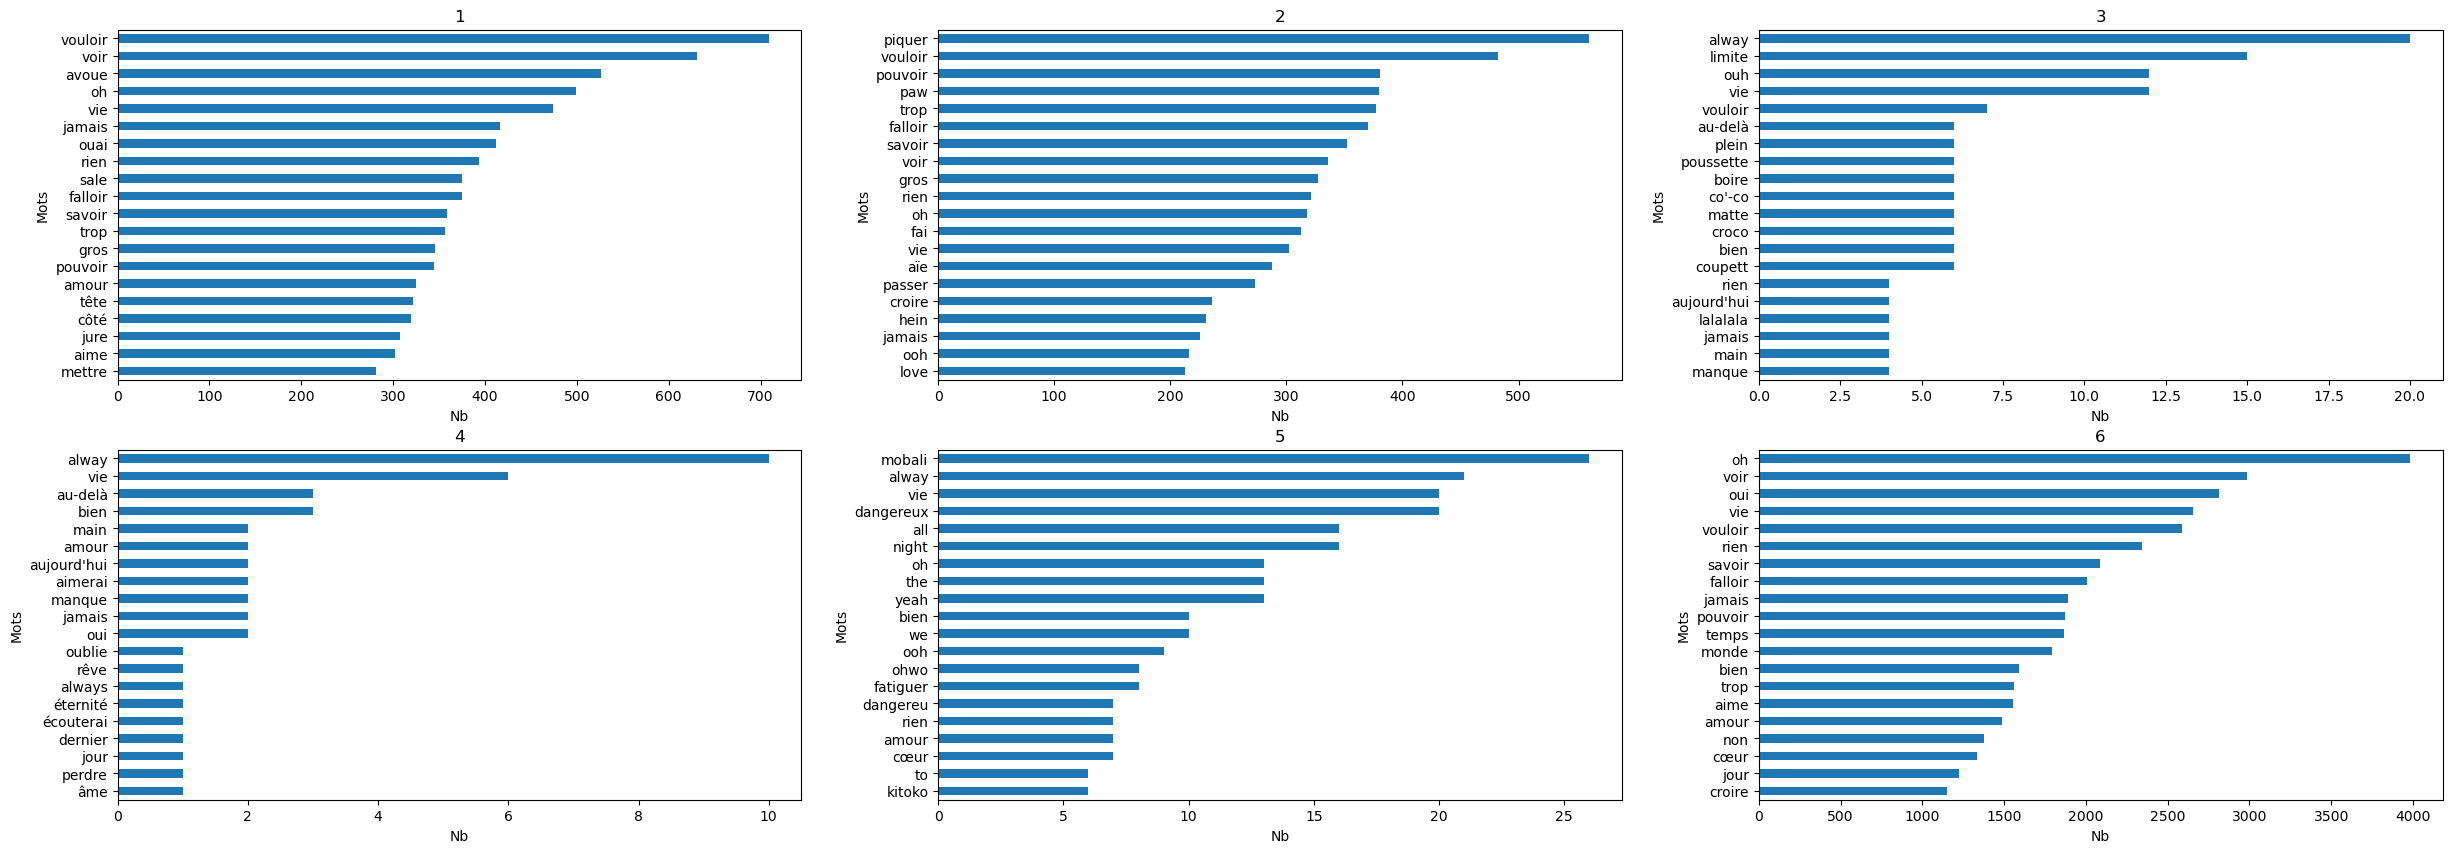

In [289]:
bag_of_words_years = compare_words(bow_charts, "cluster_charts")
plot_compare_words(bag_of_words_years, 2, 3, figsize=(30,10))

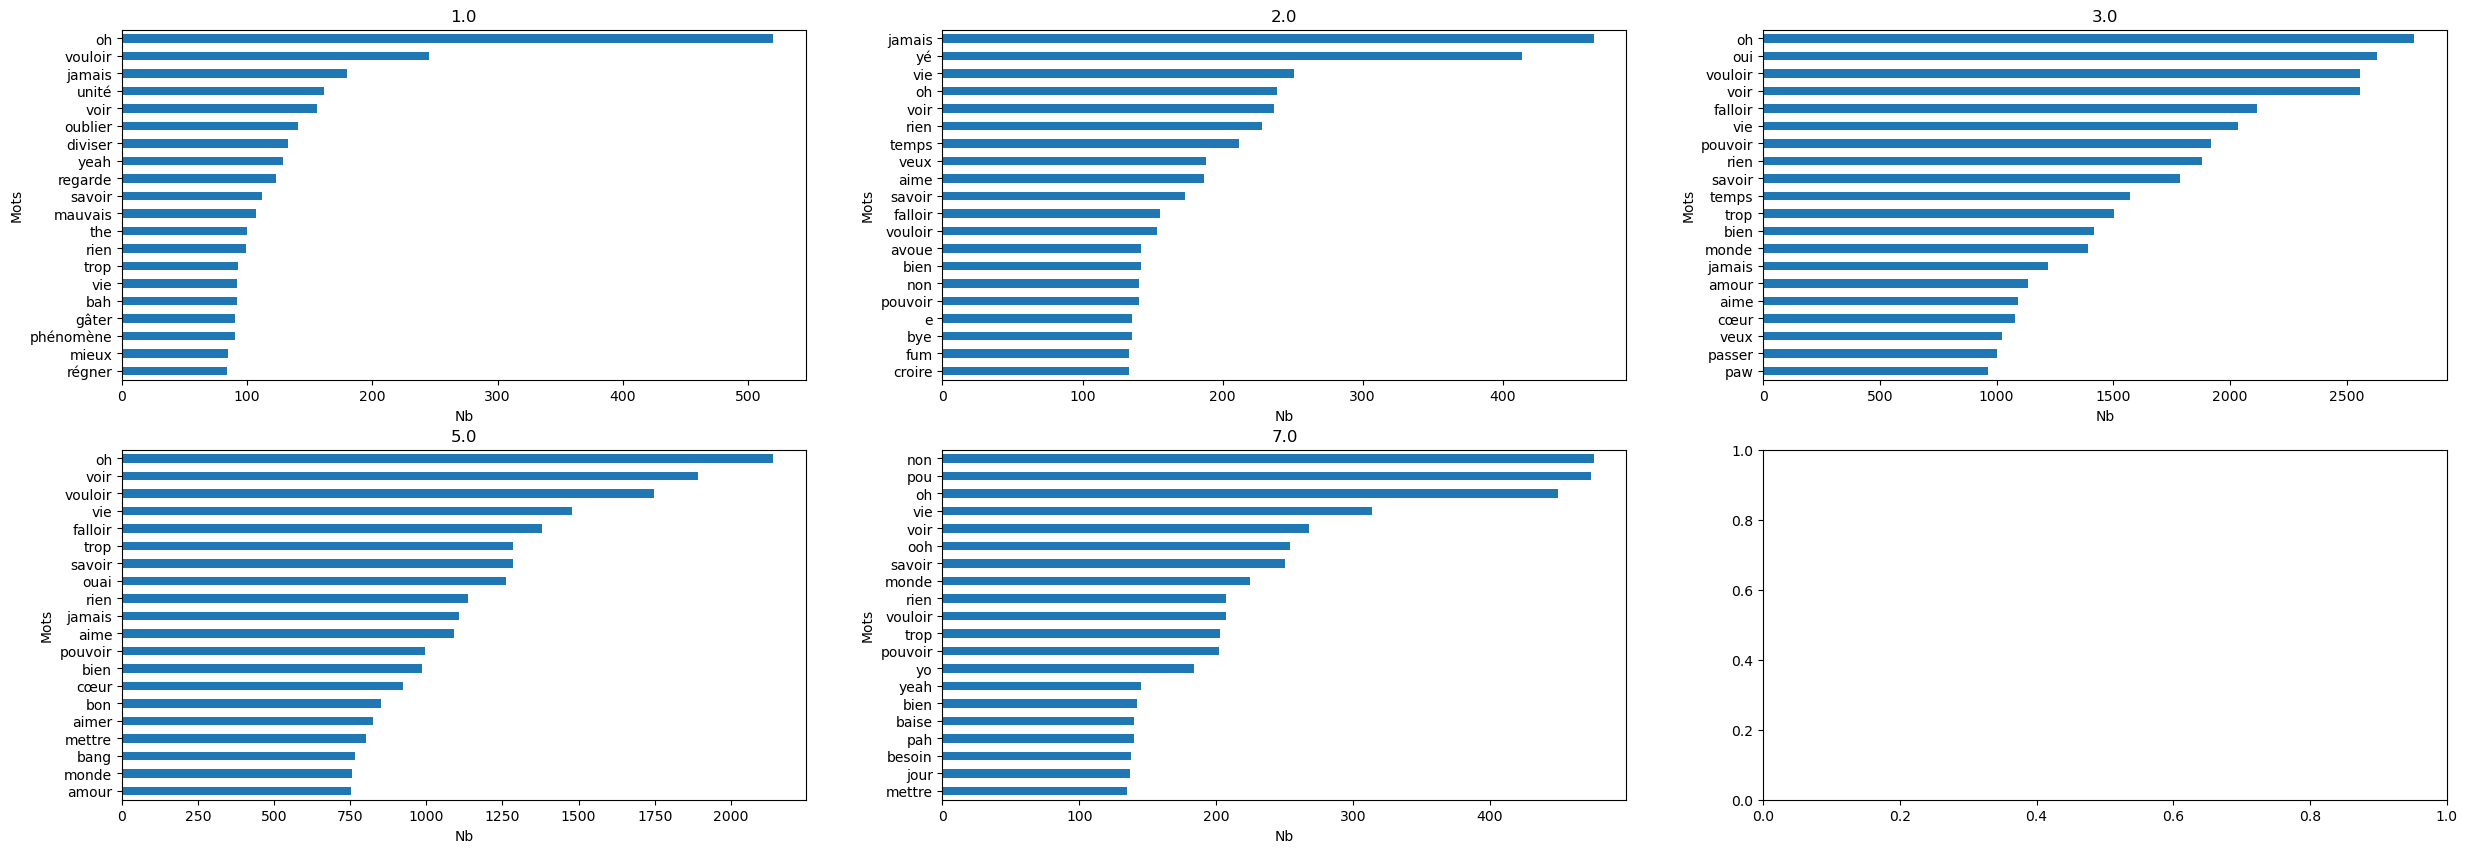

In [312]:
bag_of_words_musics = compare_words(bow_charts, "cluster_musics")
plot_compare_words(bag_of_words_musics, 2, 3, figsize=(30,10))

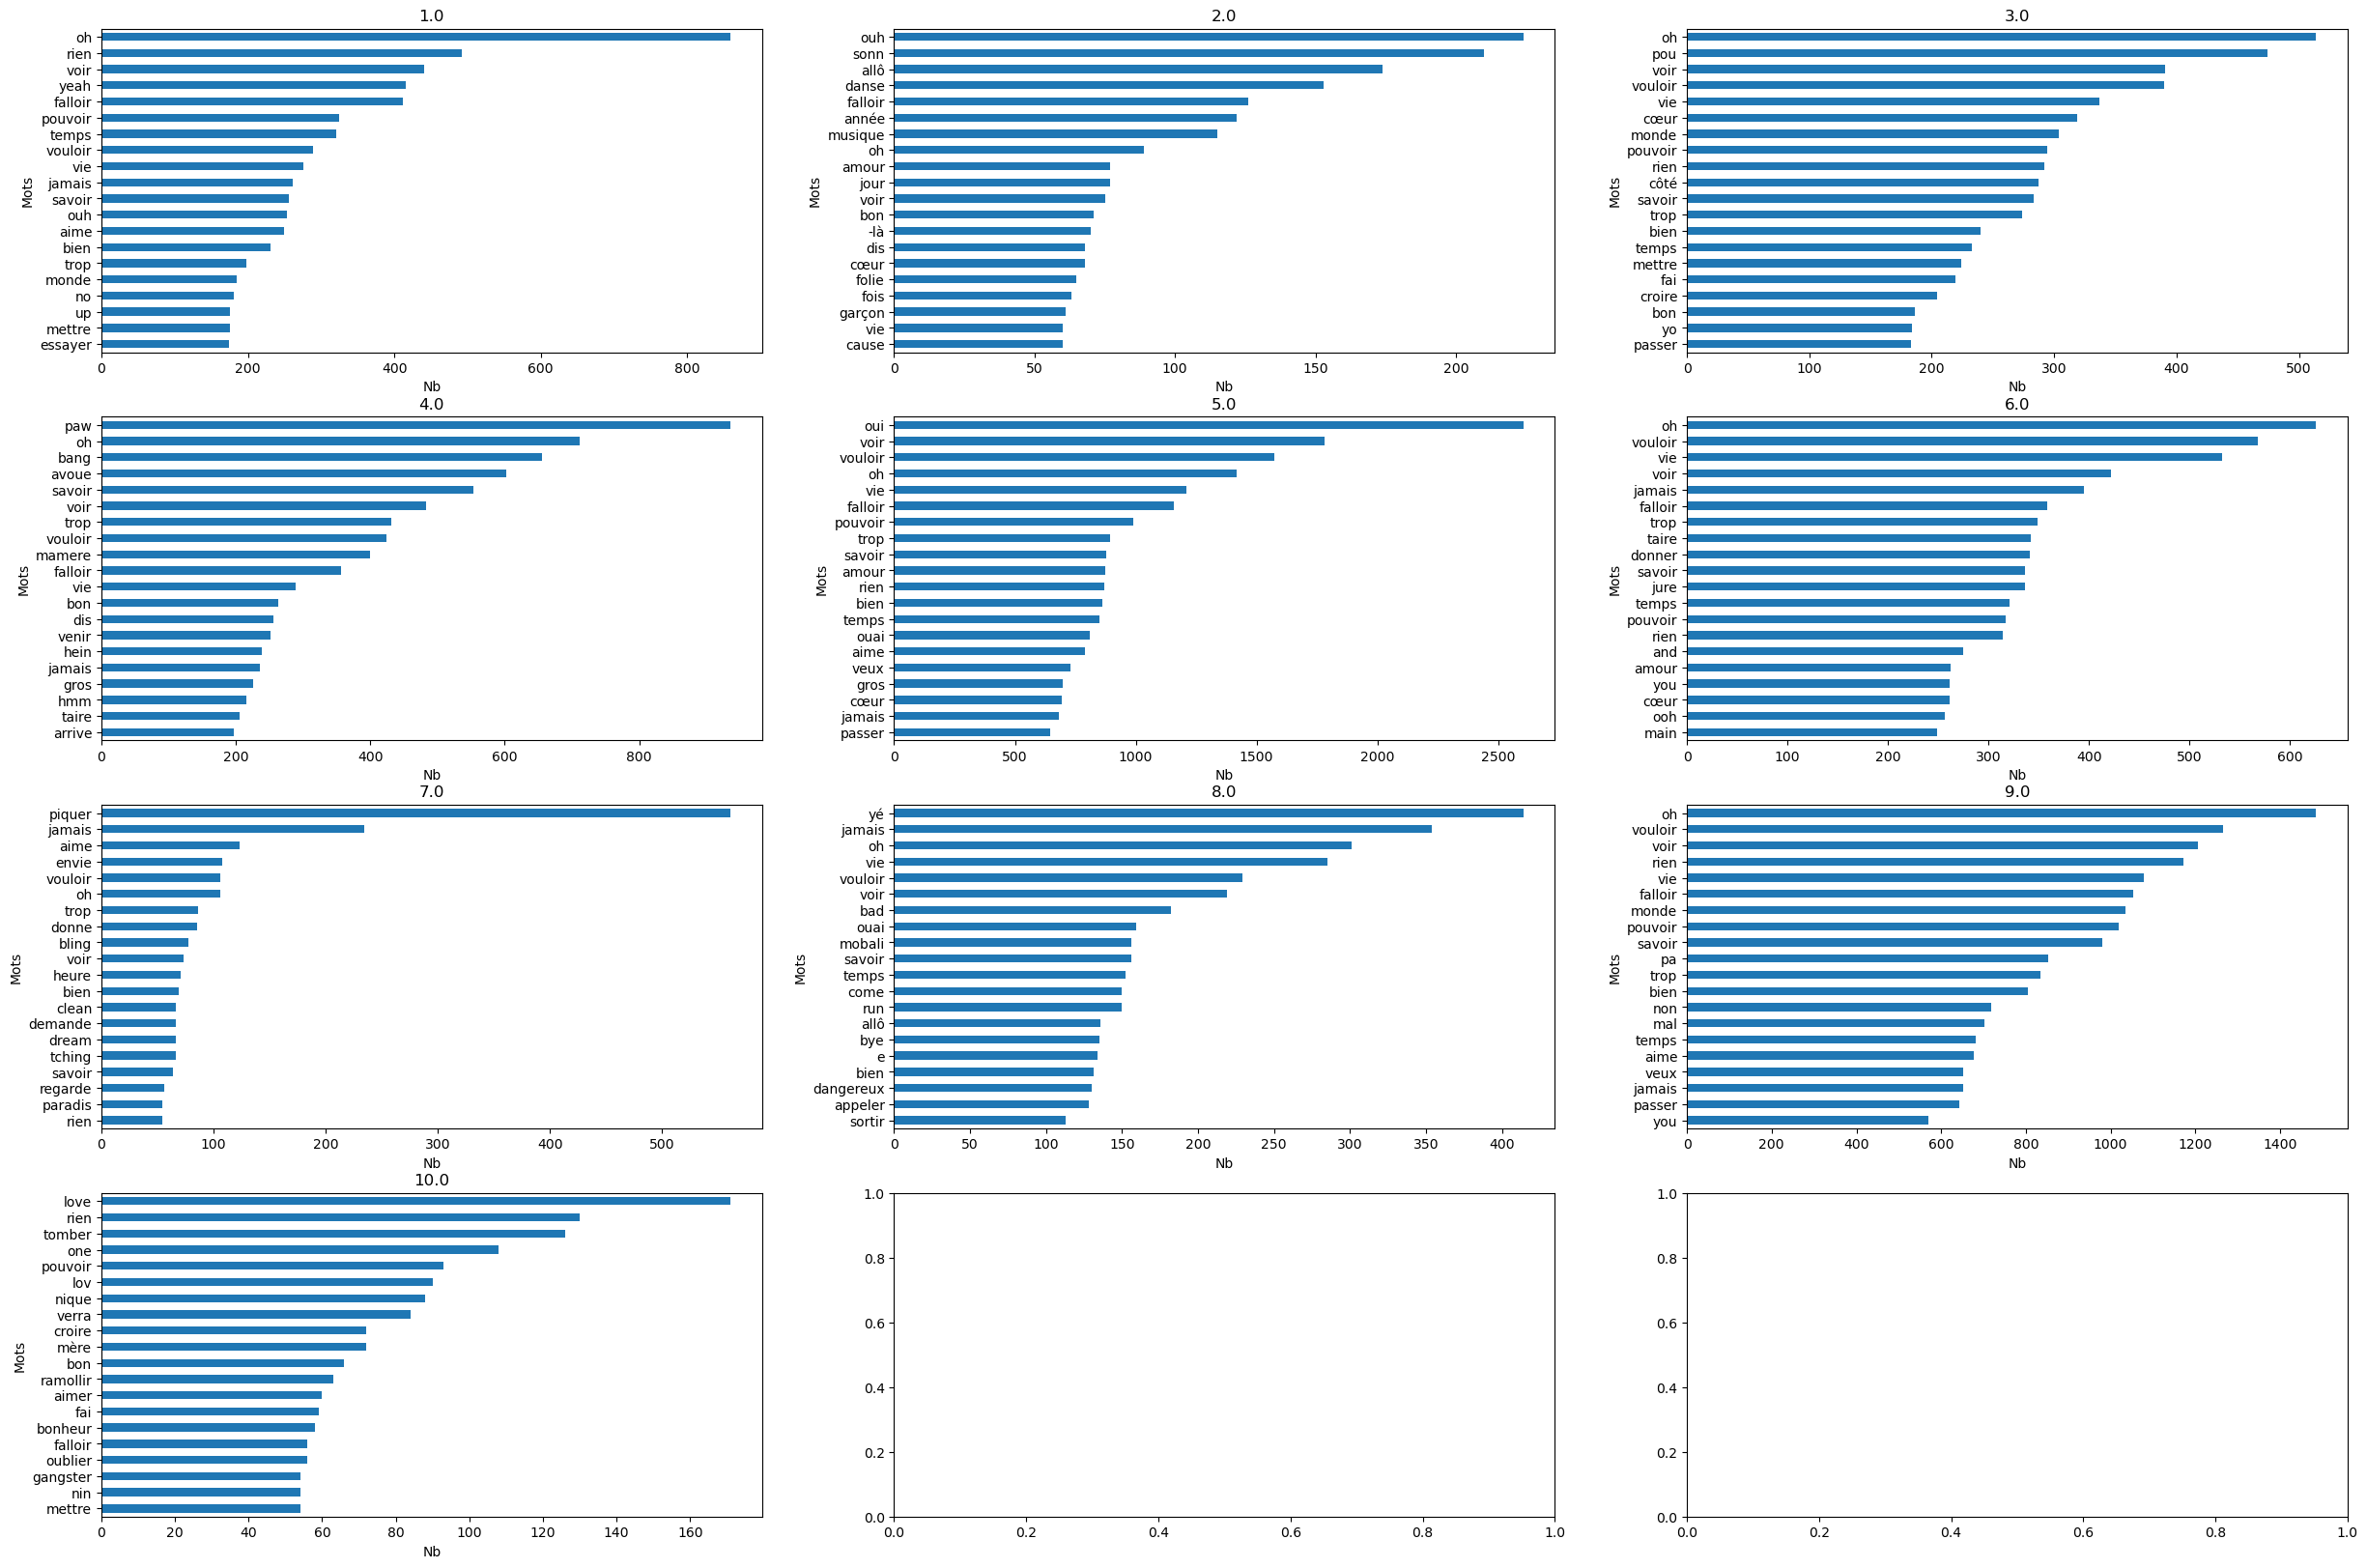

In [314]:
bag_of_words_artists = compare_words(bow_charts, "cluster_artists")
plot_compare_words(bag_of_words_artists, 4, 3, figsize=(30,20))

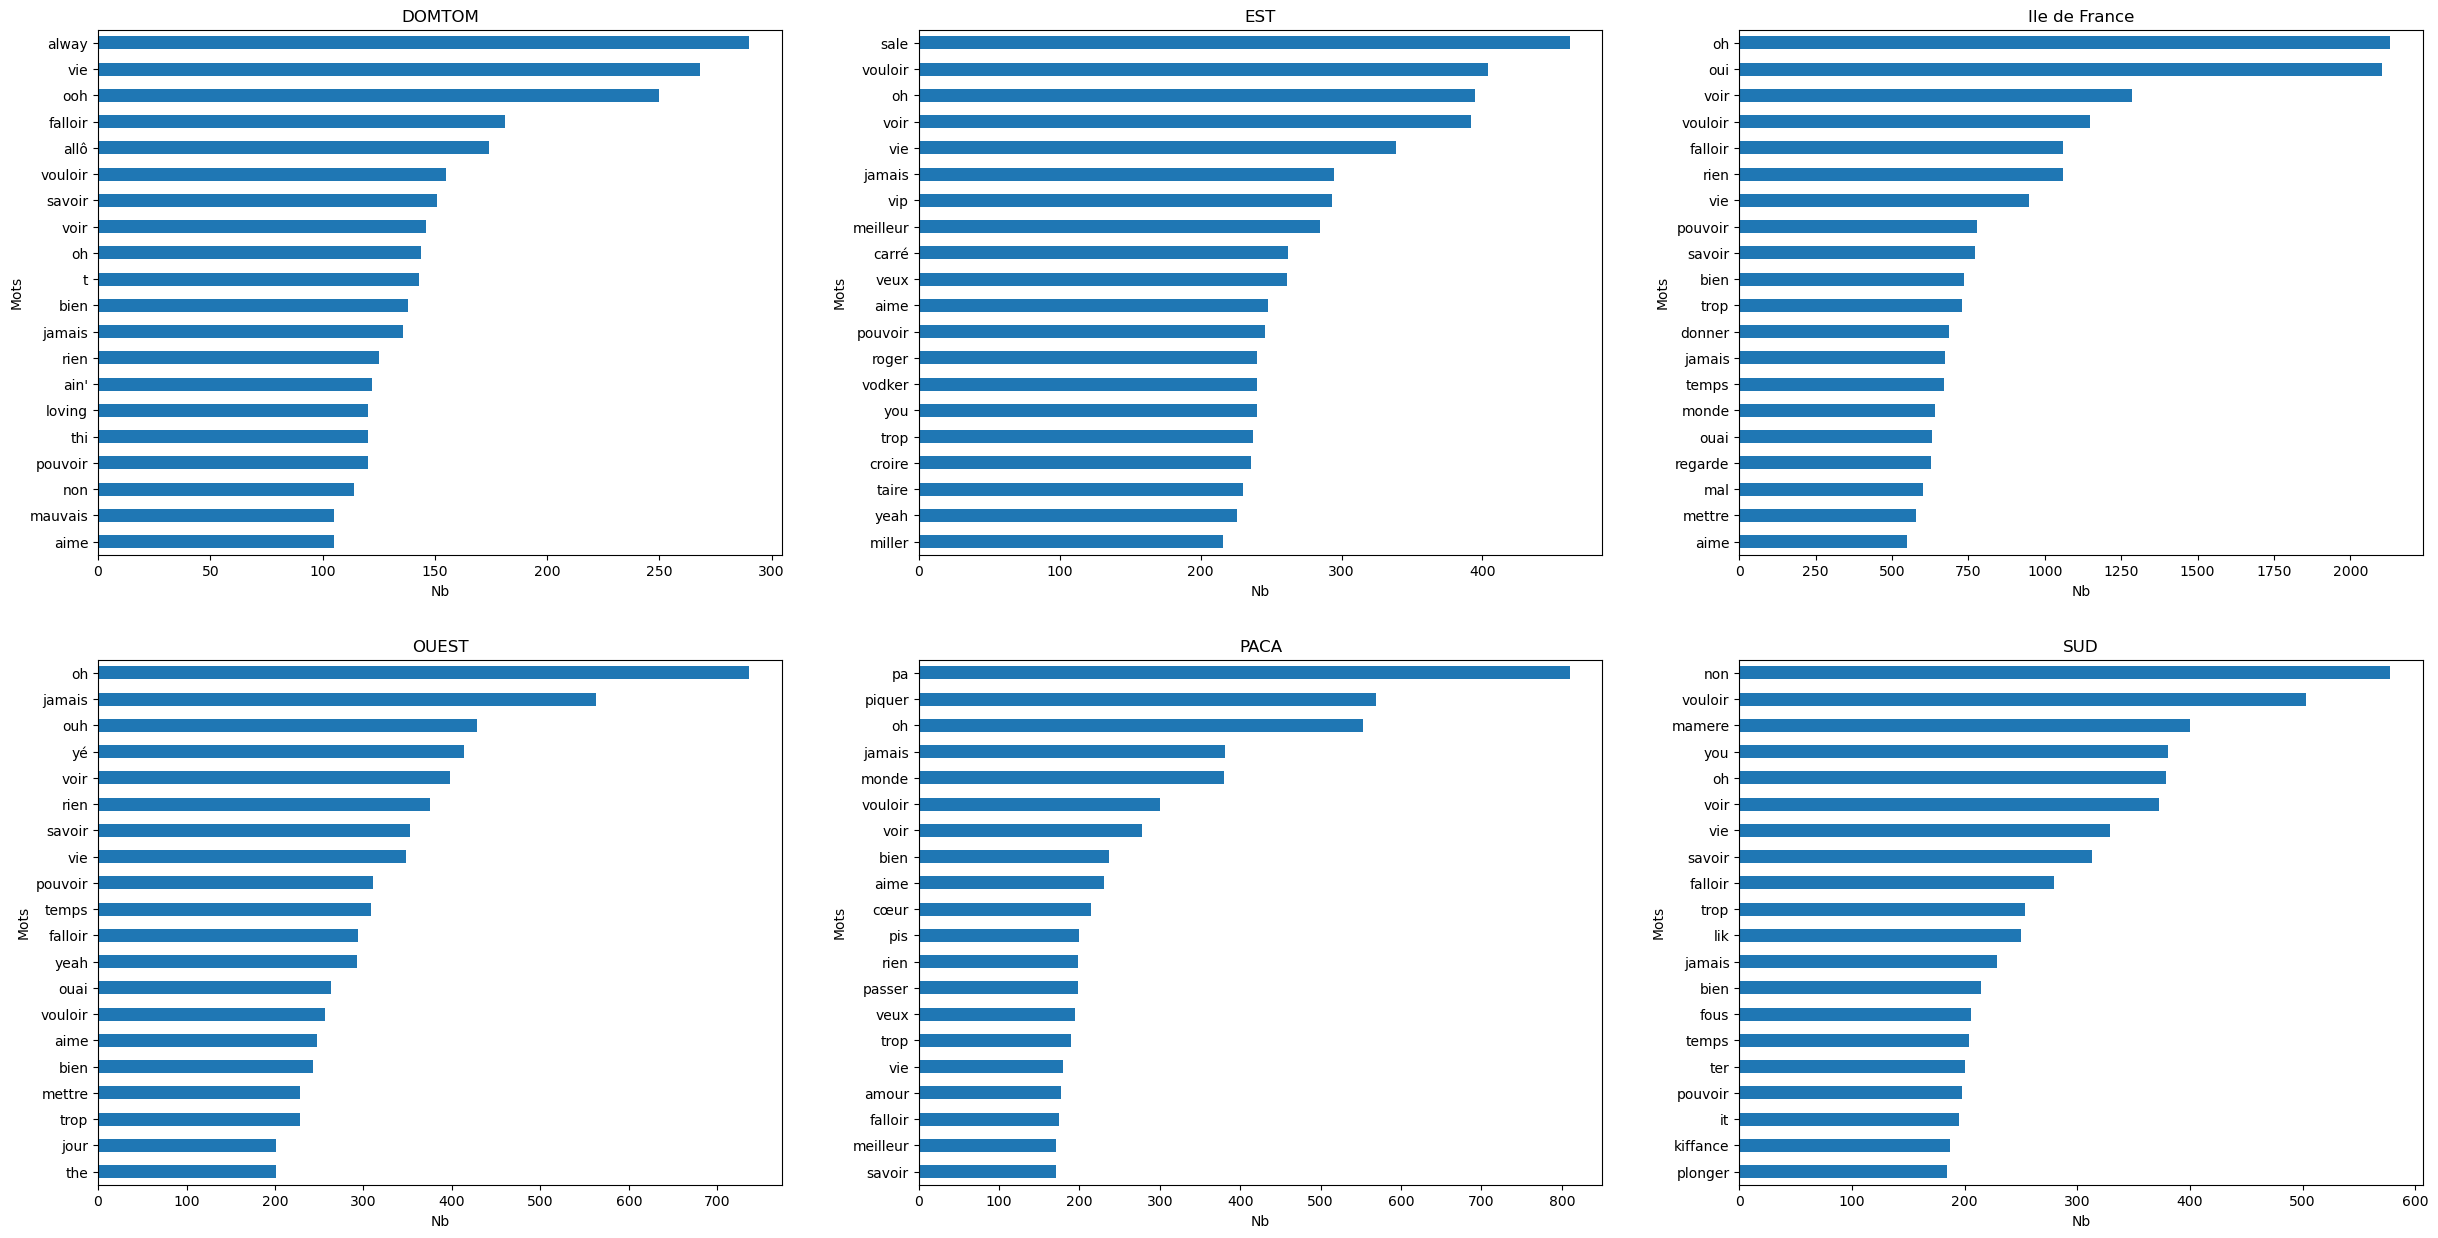

In [292]:
bag_of_words_region = compare_words(bow_charts, "region groups")
plot_compare_words(bag_of_words_region, 2, 3, figsize=(30,15))

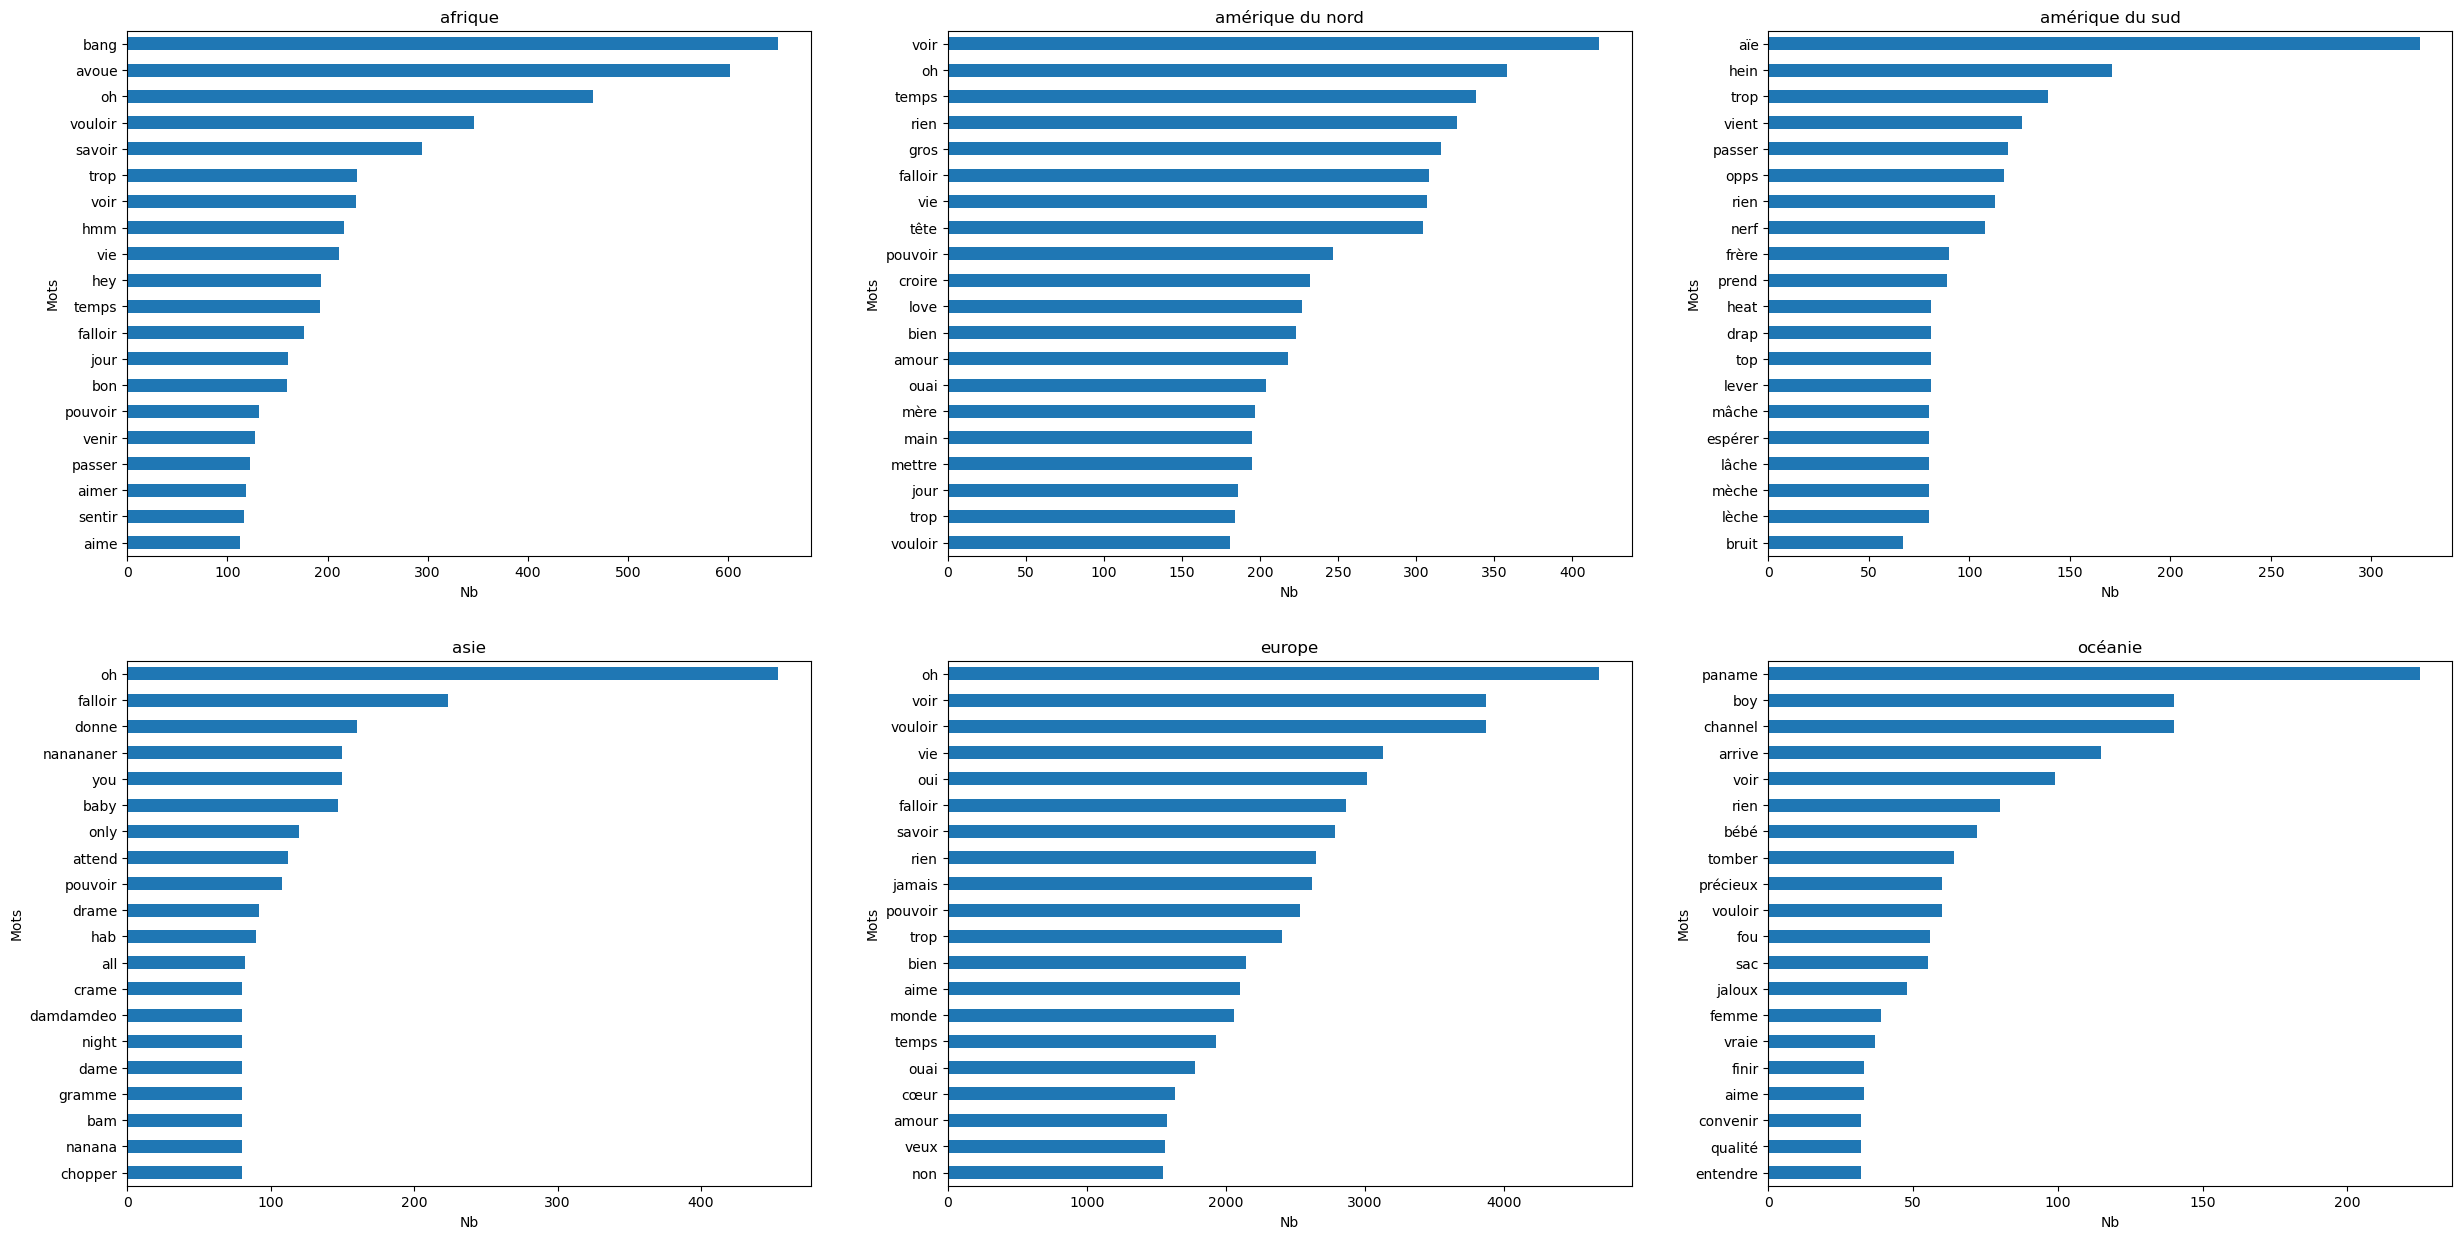

In [293]:
bag_of_words_region = compare_words(bow_charts, "continent")
plot_compare_words(bag_of_words_region, 2, 3, figsize=(30,15))

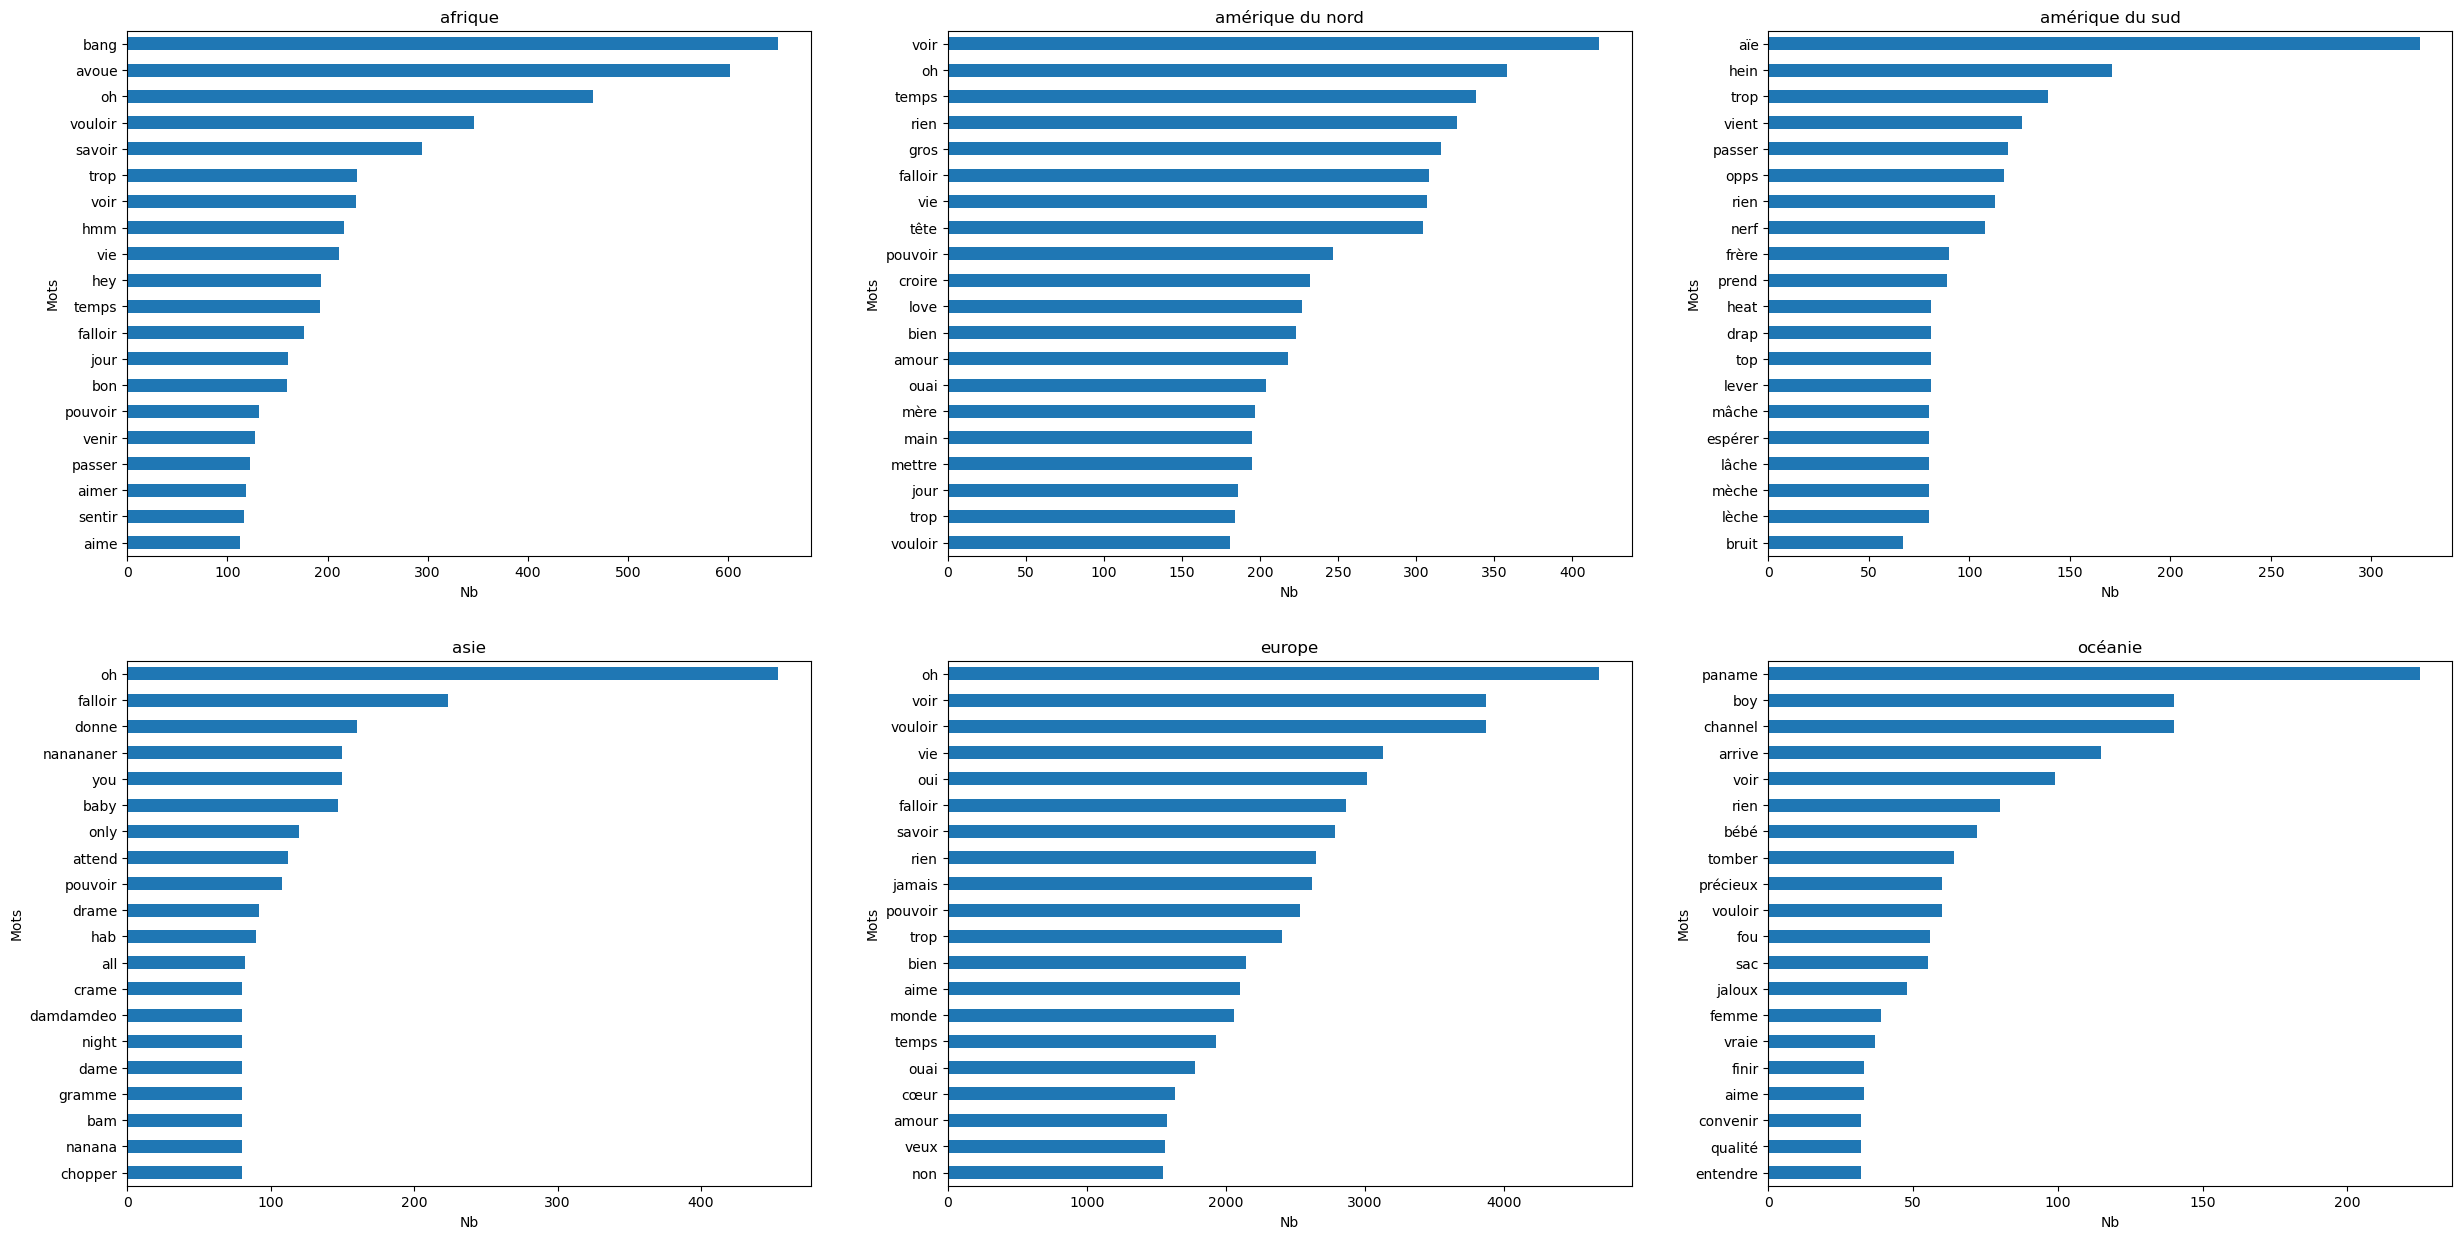

In [294]:
bag_of_words_region = compare_words(bow_charts, "continent")
plot_compare_words(bag_of_words_region, 2, 3, figsize=(30,15))

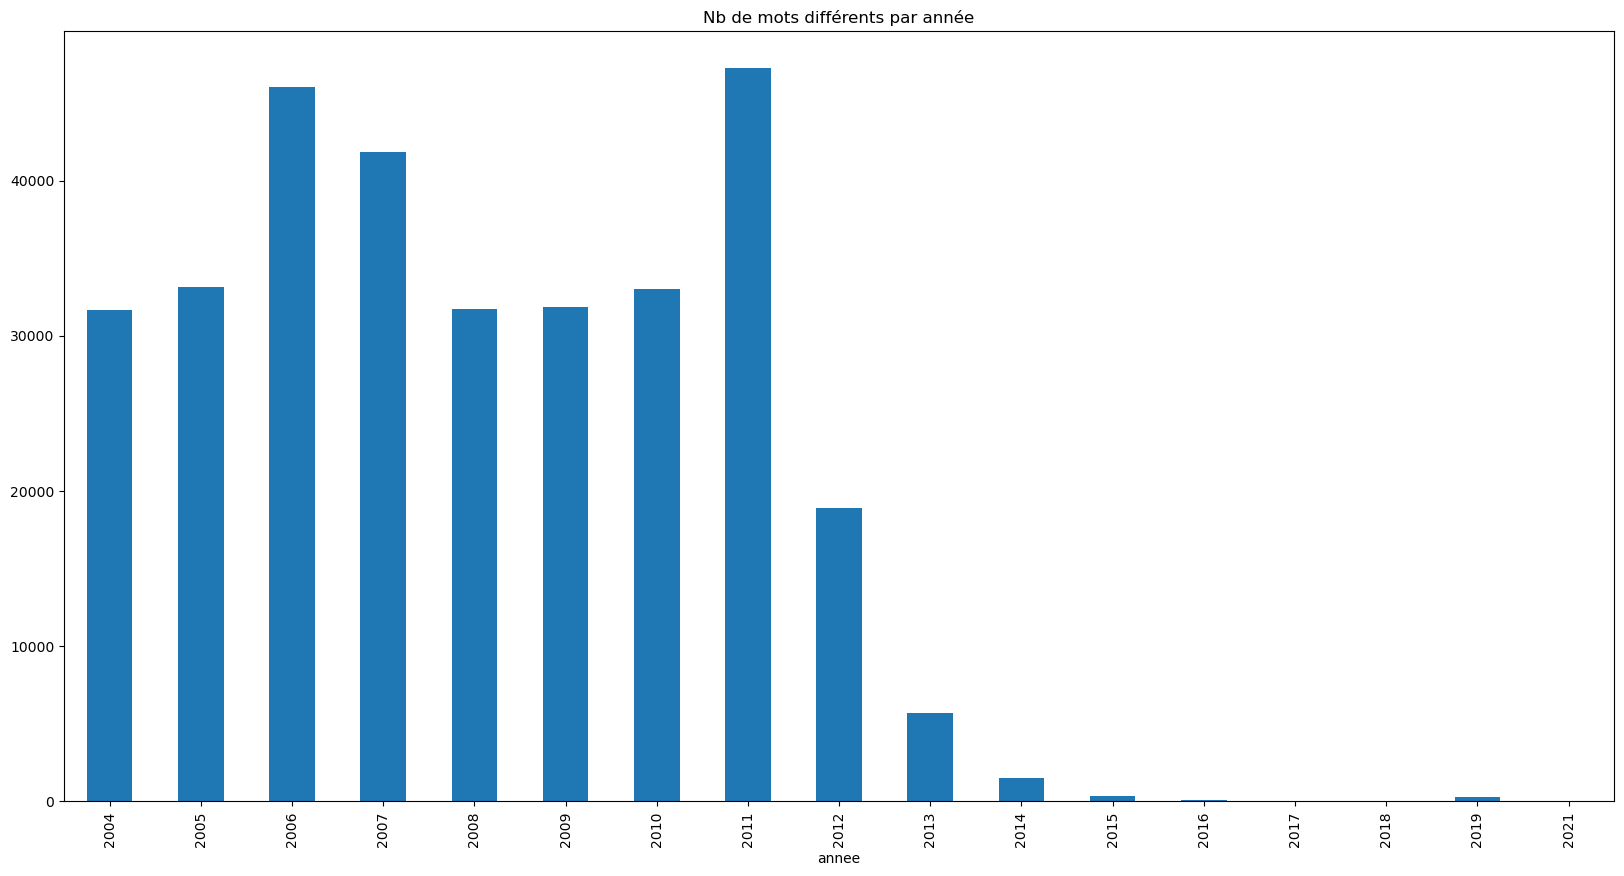

In [295]:
bow_charts.groupby("annee")["mot"].count().plot.bar(figsize=(20, 10), title="Nb de mots différents par année")
plt.show()

In [296]:
evolution_of_words = bow_charts.groupby(["annee", "mot"])["nb"].sum().unstack().fillna(0).T
evolution_of_words["sum"] = evolution_of_words.sum(axis=1)

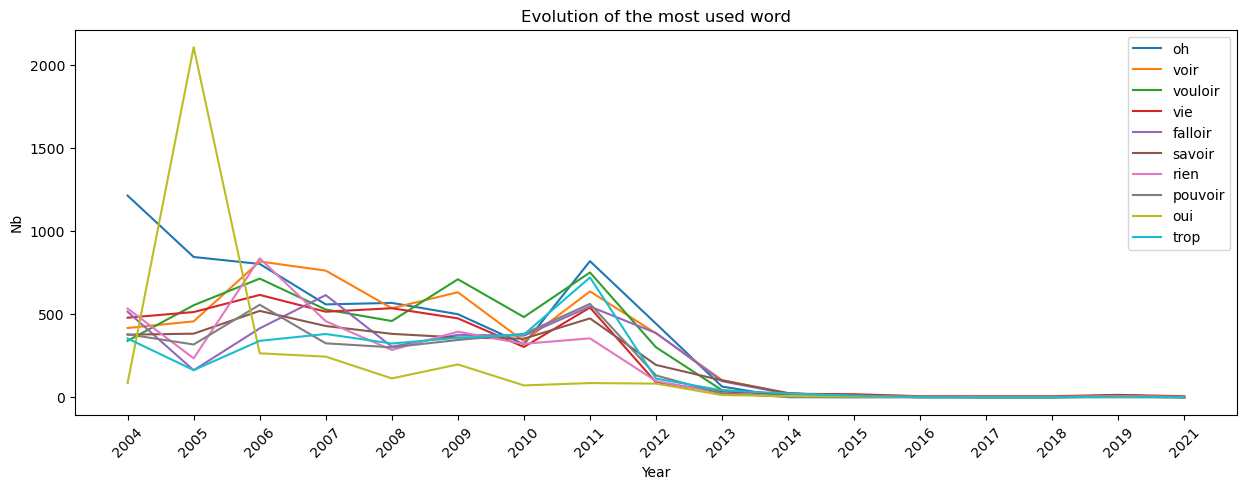

In [297]:
DEBUT = 0

plt.figure(figsize=(15, 5))

for value in evolution_of_words.sort_values("sum", ascending=False).iloc[DEBUT:DEBUT+10, :-1].values:
    plt.plot(value)

plt.xticks(range(len(value)), evolution_of_words.drop(columns=["sum"]).columns, rotation=45)
plt.title("Evolution of the most used word")
plt.legend(evolution_of_words.sort_values("sum", ascending=False).iloc[DEBUT:DEBUT+10, :-1].index)
plt.xlabel("Year")
plt.ylabel("Nb")
plt.show()

# Power bi files

In [298]:
#import
musics = pd.read_csv(f"{etapes_path}bag of words/musics.csv")
charts = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig")
artists = pd.read_csv(f"{etapes_path}cleanning wikipedia results/add_id/artists.csv", encoding="utf-8-sig")
bag_of_words = pd.read_csv(f"{etapes_path}bag of words/bag_of_words.csv")

In [299]:
artists.drop(columns=["pays", "origine", "pays d'origine", "naissance", "wiki name"], inplace=True)

In [300]:
for col in ["jour", "annee"]:
    artists[col] = artists[col].fillna(0)

In [301]:
for col in ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']:
    musics[col].fillna(musics[col].mean(), inplace=True)
    musics[col] = musics[col].astype(float)

for col in ['key', 'mode', 'time_signature', 'duration_ms']:
    musics[col].fillna(musics[col].value_counts(ascending=False).values[0], inplace=True)
    musics[col] = musics[col].astype(int)

In [302]:
region = gpd.read_file("../../shapefile/region/regions-20180101.shp")
region.drop(columns=["code_insee", "nuts2", "wikipedia", "surf_km2"], inplace=True)
region["nom"] = region["nom"].str.lower()

In [303]:
departement = gpd.read_file("../../shapefile/departement/georef-france-departement-millesime.shp", encoding="utf-8")
departement.drop(columns=["year", "reg_code", "dep_code", "dep_current", "reg_name", "dep_name_up", "dep_name_lo", "dep_area_co", "dep_type", "dep_status", "dep_siren_c", "dep_is_ctu"], inplace=True)
departement.rename(columns={"dep_name": "nom"}, inplace=True)
departement["nom"] = departement["nom"].str.lower()

In [304]:
region_name = pd.DataFrame(region["nom"].unique(), columns=["nom"])
departement_name = pd.DataFrame(departement["nom"].unique(), columns=["nom"])

In [305]:
homogene_region = region_name["nom"].apply(lambda x : homogeneous_data(x, artists["region"]))
homogene_departement = departement_name["nom"].apply(lambda x : homogeneous_data(x, artists["departement"]))

In [306]:
region_name["homogene"] = homogene_region
departement_name["homogene"] = homogene_departement

In [307]:
region = region.merge(region_name, on="nom", how="left").drop(columns=["nom"]).rename(columns={"homogene": "nom"})
departement = departement.merge(departement_name, on="nom", how="left").drop(columns=["nom"]).rename(columns={"homogene": "nom"})

In [308]:
region.to_file("../../shapefile/region/region_homegone.shp")
departement.to_file("../../shapefile/departement/departement_homegone.shp")

c:\Users\quent\anaconda3\envs\parole_musique\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\quent\anaconda3\envs\parole_musique\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [309]:
#Ajout de l'age des artists lorsque le morceau à été dans le top 100
annee = artists.merge(charts, on="id_artist", how="left").rename(columns={"annee_x" : "annee_artist", "annee_y" : "annee_chart"})[["annee_artist", "annee_chart"]].copy()
annee["age_artist_atm"] = annee["annee_chart"] - annee["annee_artist"]  #Calcul de l'age des artists
annee.loc[annee["annee_artist"] == 0, "age_artist_atm"] = 0             #On enleve les artists qui n'ont pas d'age
annee.loc[annee["age_artist_atm"] > 120, "age_artist_atm"] = 0          #On enleve les valeurs aberantes

In [310]:
charts = charts.merge(annee["age_artist_atm"], left_index=True, right_index=True)
charts.drop(columns=["music"], inplace=True)

In [311]:
musics.to_csv(f"{etapes_path}power bi/musics.csv", encoding="utf-8-sig", index=False)
charts.to_csv(f"{etapes_path}power bi/charts.csv", encoding="utf-8-sig", index=False)
artists.to_csv(f"{etapes_path}power bi/artists.csv", encoding="utf-8-sig", index=False)
bag_of_words.to_csv(f"{etapes_path}power bi/bag_of_words.csv", encoding="utf-8", index=False)

# A Faire
- Dendogramme pour le clustering
- Analyse au fil des années des différentes features
- Proportion des différents clusters au fil des ans
- Stats avec les ages